In [71]:
using Revise
using GLMakie
using Arya

In [2]:
import DensityEstimators as DE

In this notebook, I investigate some methods for calculating the density :)

In [3]:
import Distributions: Normal, pdf, Distributions

In [4]:
using Optim

In [5]:
import StatsBase: quantile

In [6]:
import QuadGK: quadgk

# Distributions

In [9]:
dist_normal = Normal(0., π/3)

Normal{Float64}(μ=0.0, σ=1.0471975511965976)

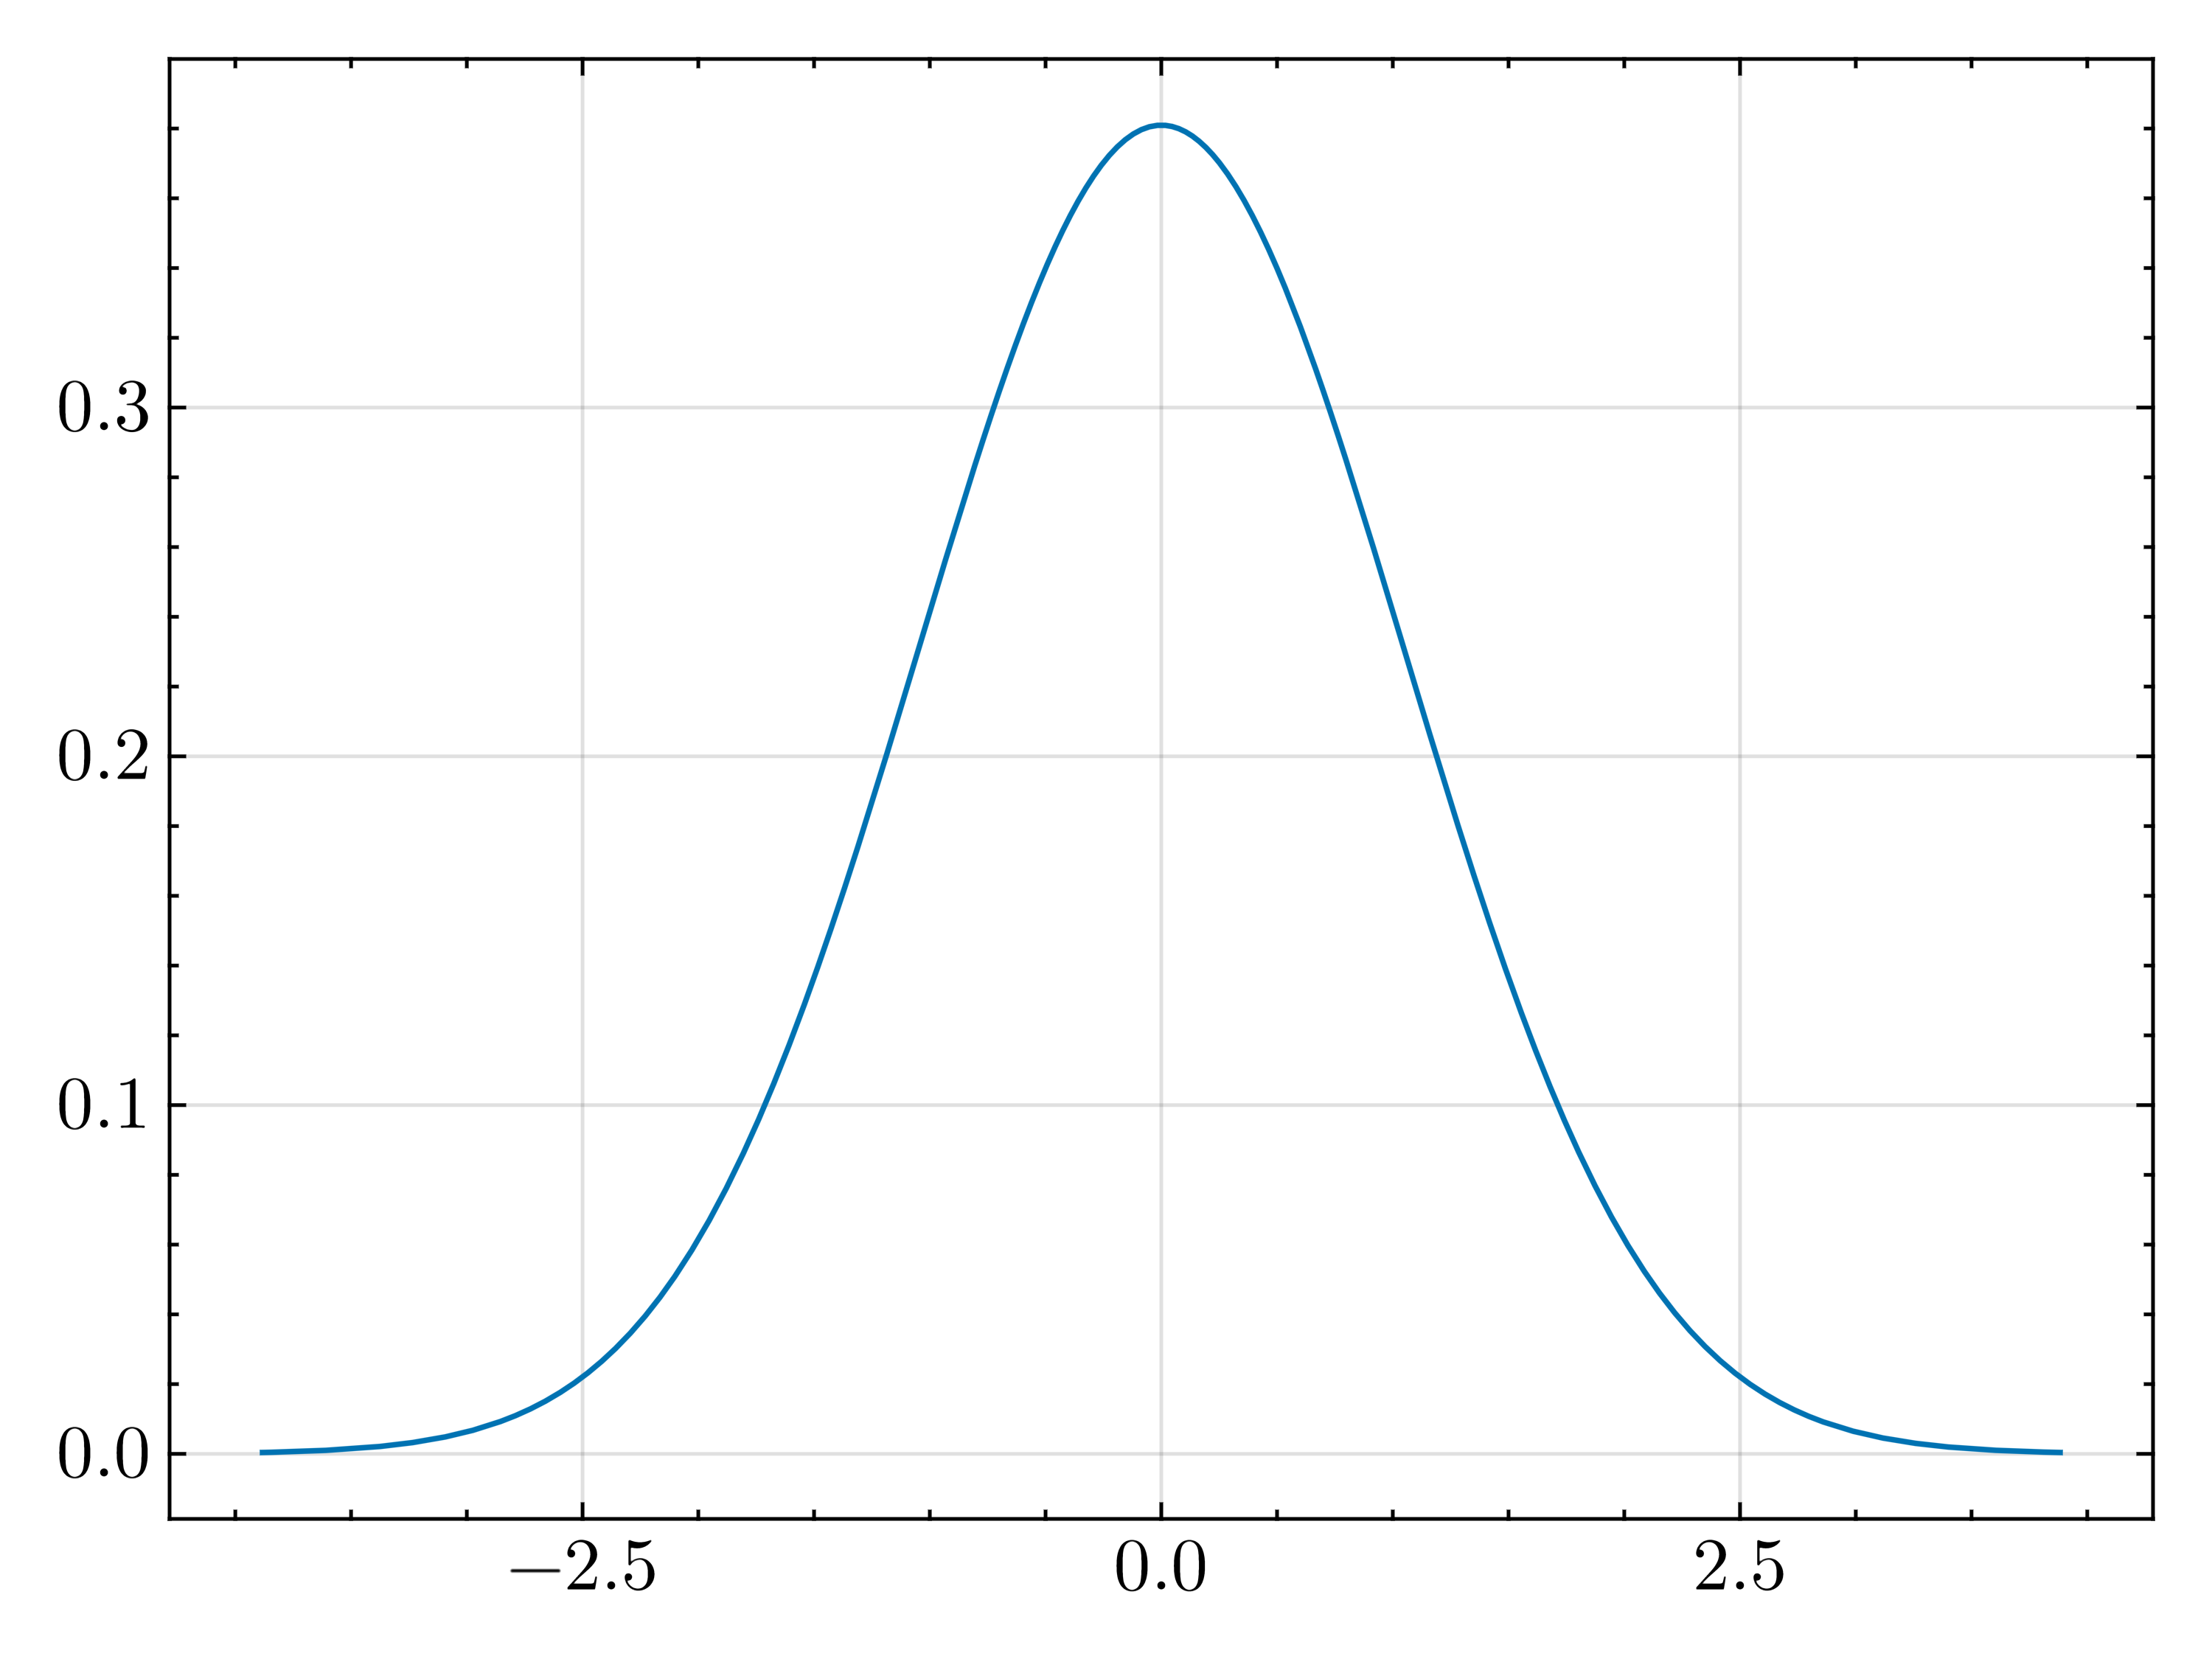

In [10]:
plot(dist_normal)

In [11]:
function plot_derivative!(dist, x=LinRange(-5, 5, 10000))
    y = pdf.(dist, x)
    y1 = DE.gradient(y, x)

    lines!(x, y1)
end


plot_derivative! (generic function with 2 methods)

In [12]:
function plot_d2!(dist, x=LinRange(-5, 5, 10000))
    y = pdf.(dist, x)
    y1 = DE.gradient(y, x)
    y2 = DE.gradient(y1, x)
    
    lines!(x, y2)
end


plot_d2! (generic function with 2 methods)

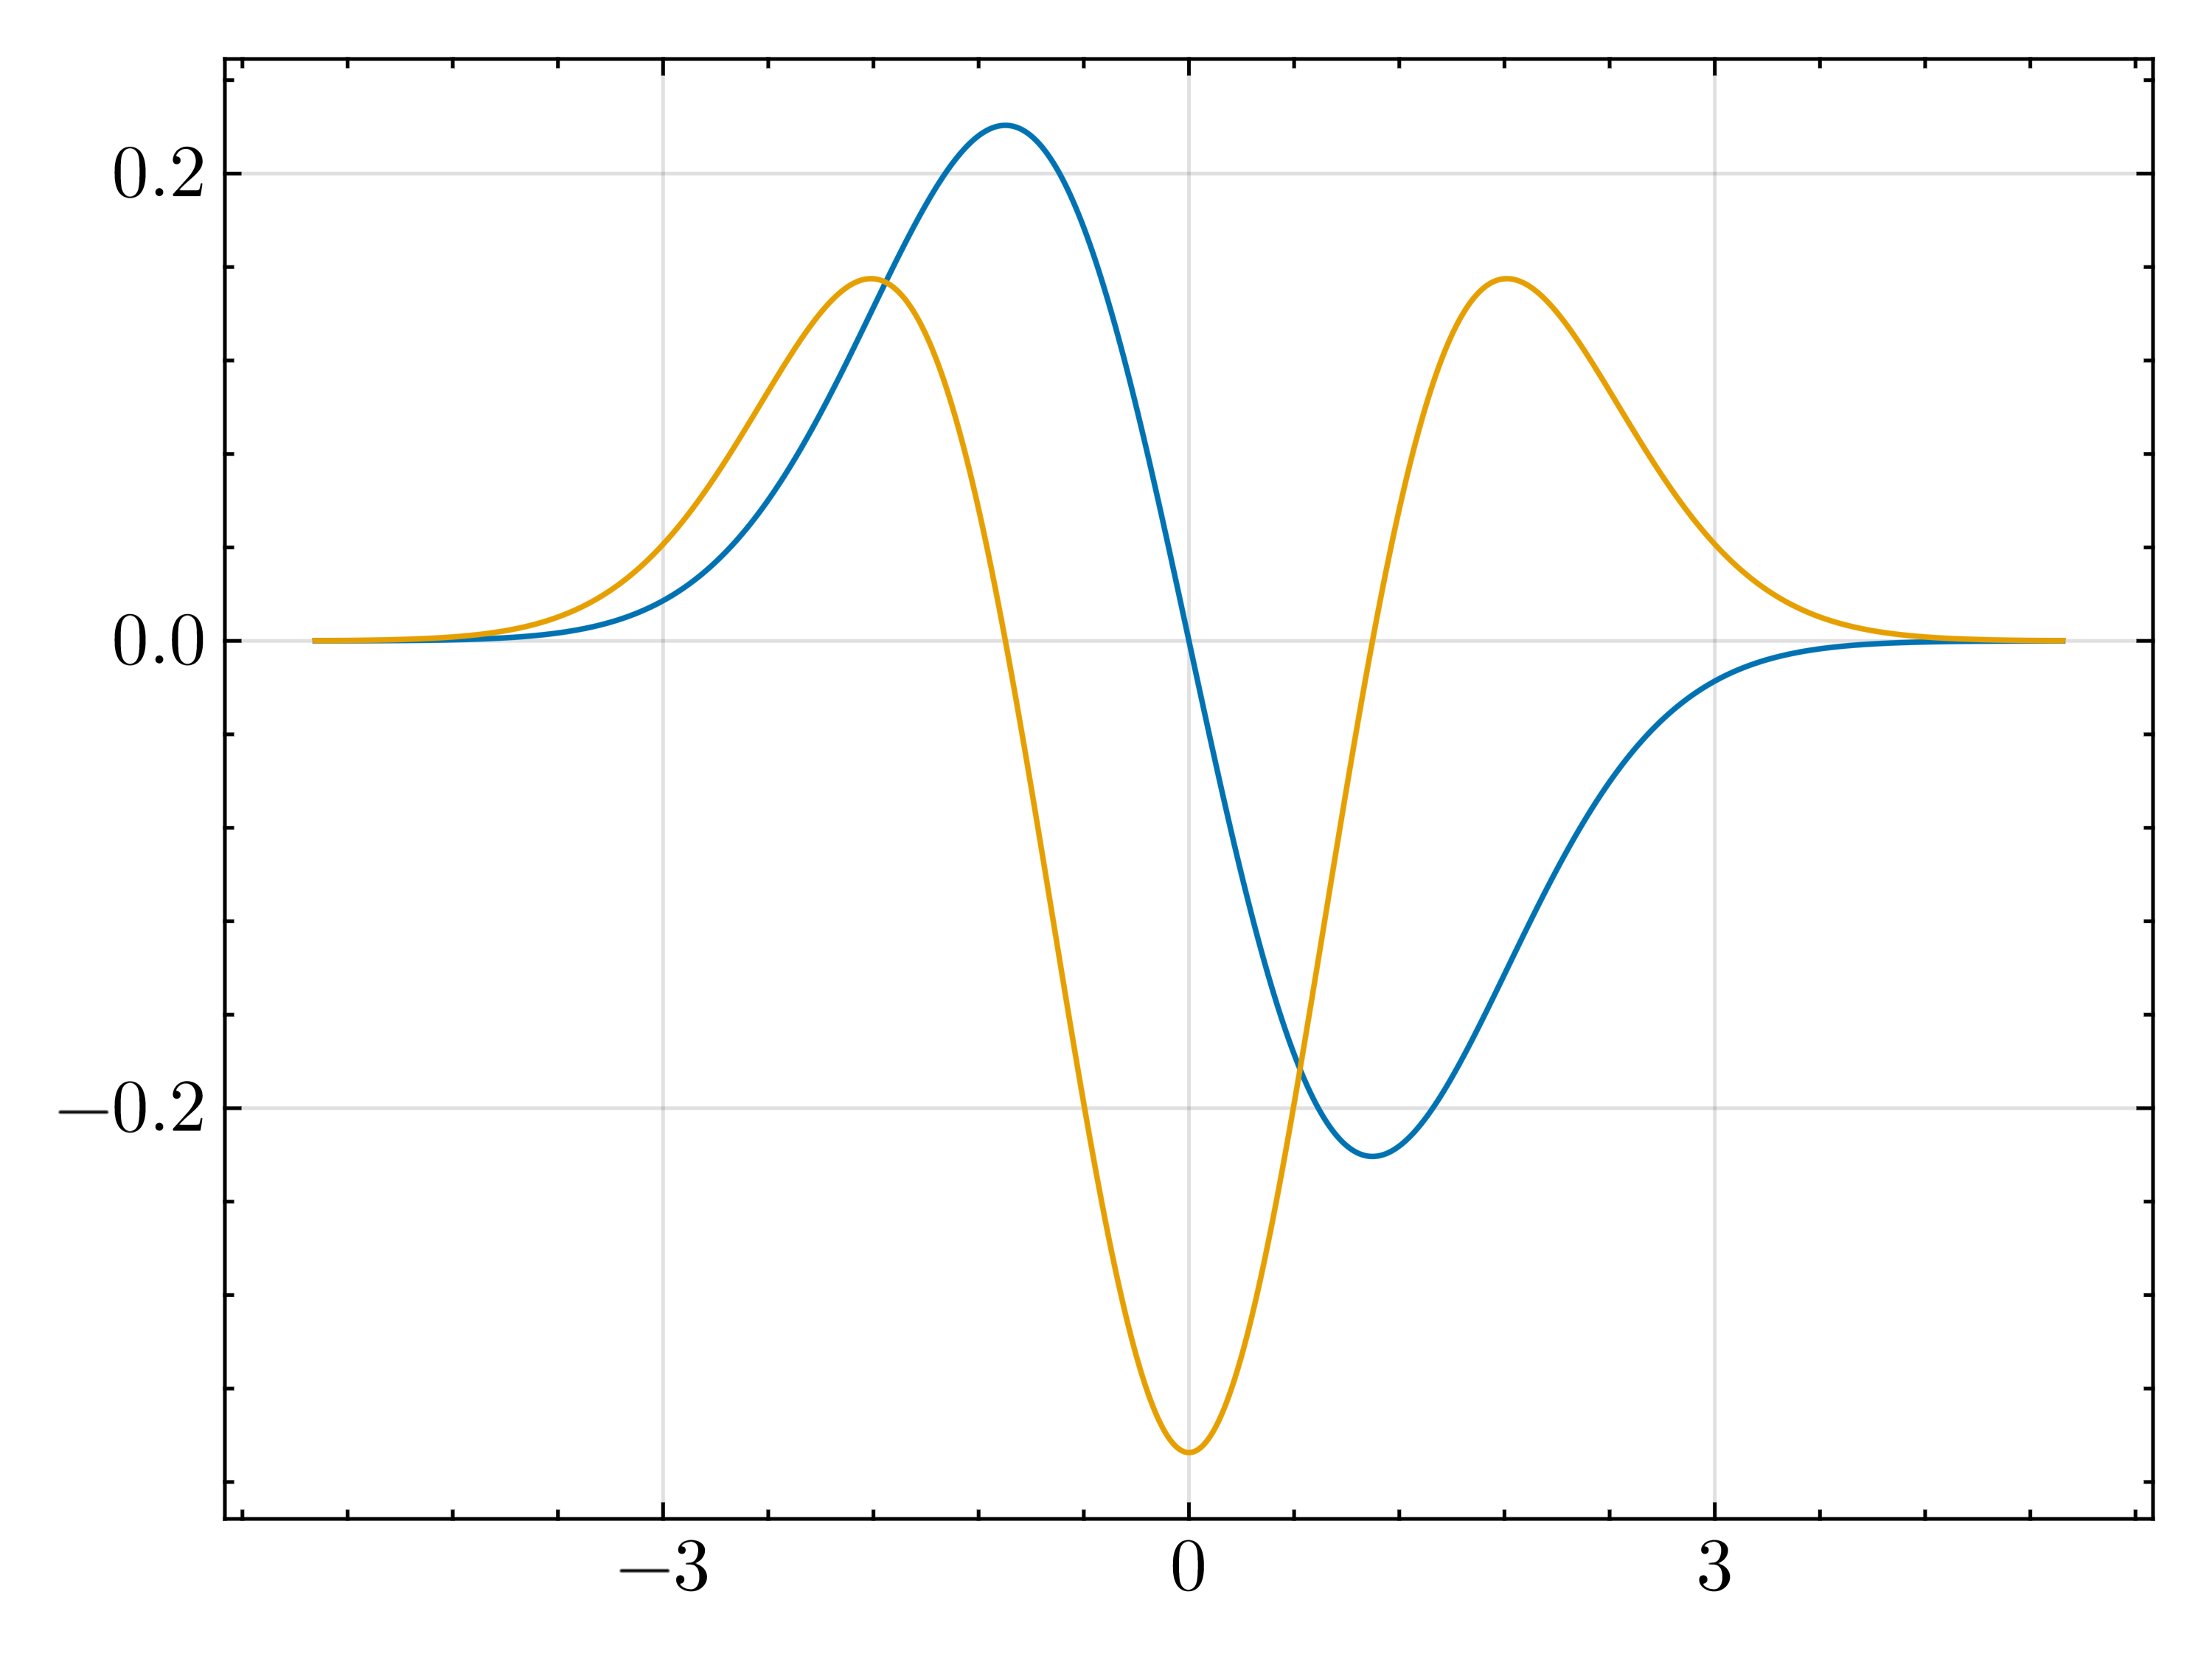

In [13]:
fig, ax = FigAxis()

plot_derivative!(dist_normal)
plot_d2!(dist_normal)

fig

# BSpline

In [14]:
N = 1_000
x = rand(dist_normal, N);

## Primal spline

In [15]:
Nk = 60
k_0 = LinRange(minimum(x), maximum(x), Nk)
#k_0 = quantile(x, LinRange(0, 1, Nk));
order = 4
k_0 = DE.pad_knots(k_0, order)

a_0 = rand(Nk)

60-element Vector{Float64}:
 0.9413879830060055
 0.9053511636594752
 0.5942214683759013
 0.4845781422724489
 0.3545678060528973
 0.6498735775214117
 0.3125014090822499
 0.11943873417169937
 0.5694791092520054
 0.46605453745211767
 0.8657455885196155
 0.29436799641233646
 0.18260650213736462
 ⋮
 0.37733308918031405
 0.22799508013284941
 0.5136582915862966
 0.8417508945678167
 0.755267140268522
 0.05974737949633557
 0.4239791213494025
 0.05507867512186804
 0.2885781345692596
 0.4551012823040669
 0.7605643439063164
 0.9695795161083225

In [18]:
s_norm = DE.normalized_spline(k_0, a_0[1:end-1], order)

quadgk(s_norm, -10, 10)

(1.0000000011532122, 1.4436091634349297e-8)

In [19]:
s = DE.PrimalBSpline(x, k_0, order=order)

DensityEstimators.BSpline([-4.236194292659185, -4.114569740352028, -3.9929451880448705, -3.8713206357377135, -3.749696083430556, -3.628071531123399, -3.506446978816242, -3.3848224265090847, -3.263197874201927, -3.14157332189477  …  2.3315315319273036, 2.453156084234461, 2.574780636541618, 2.696405188848775, 2.8180297411559323, 2.9396542934630894, 3.0612788457702473, 3.182903398077404, 3.3045279503845606, 3.4261525026917172], [0.005483390900708014, 0.0013708477251770075, 0.0, 0.0, 0.0, 0.0007893483175194217, 0.005270606612390626, 0.0022830402860208013, 0.0037026933140321665, 0.006979509870875306  …  0.04812290498086147, 0.06281570413154029, 0.0642034270107505, 0.020353941625407403, 0.014177585372316608, 0.007607884308064086, 0.008883197920408113, 0.007199700844184213, 0.004975573526618842, 0.009987179486658481], 4)

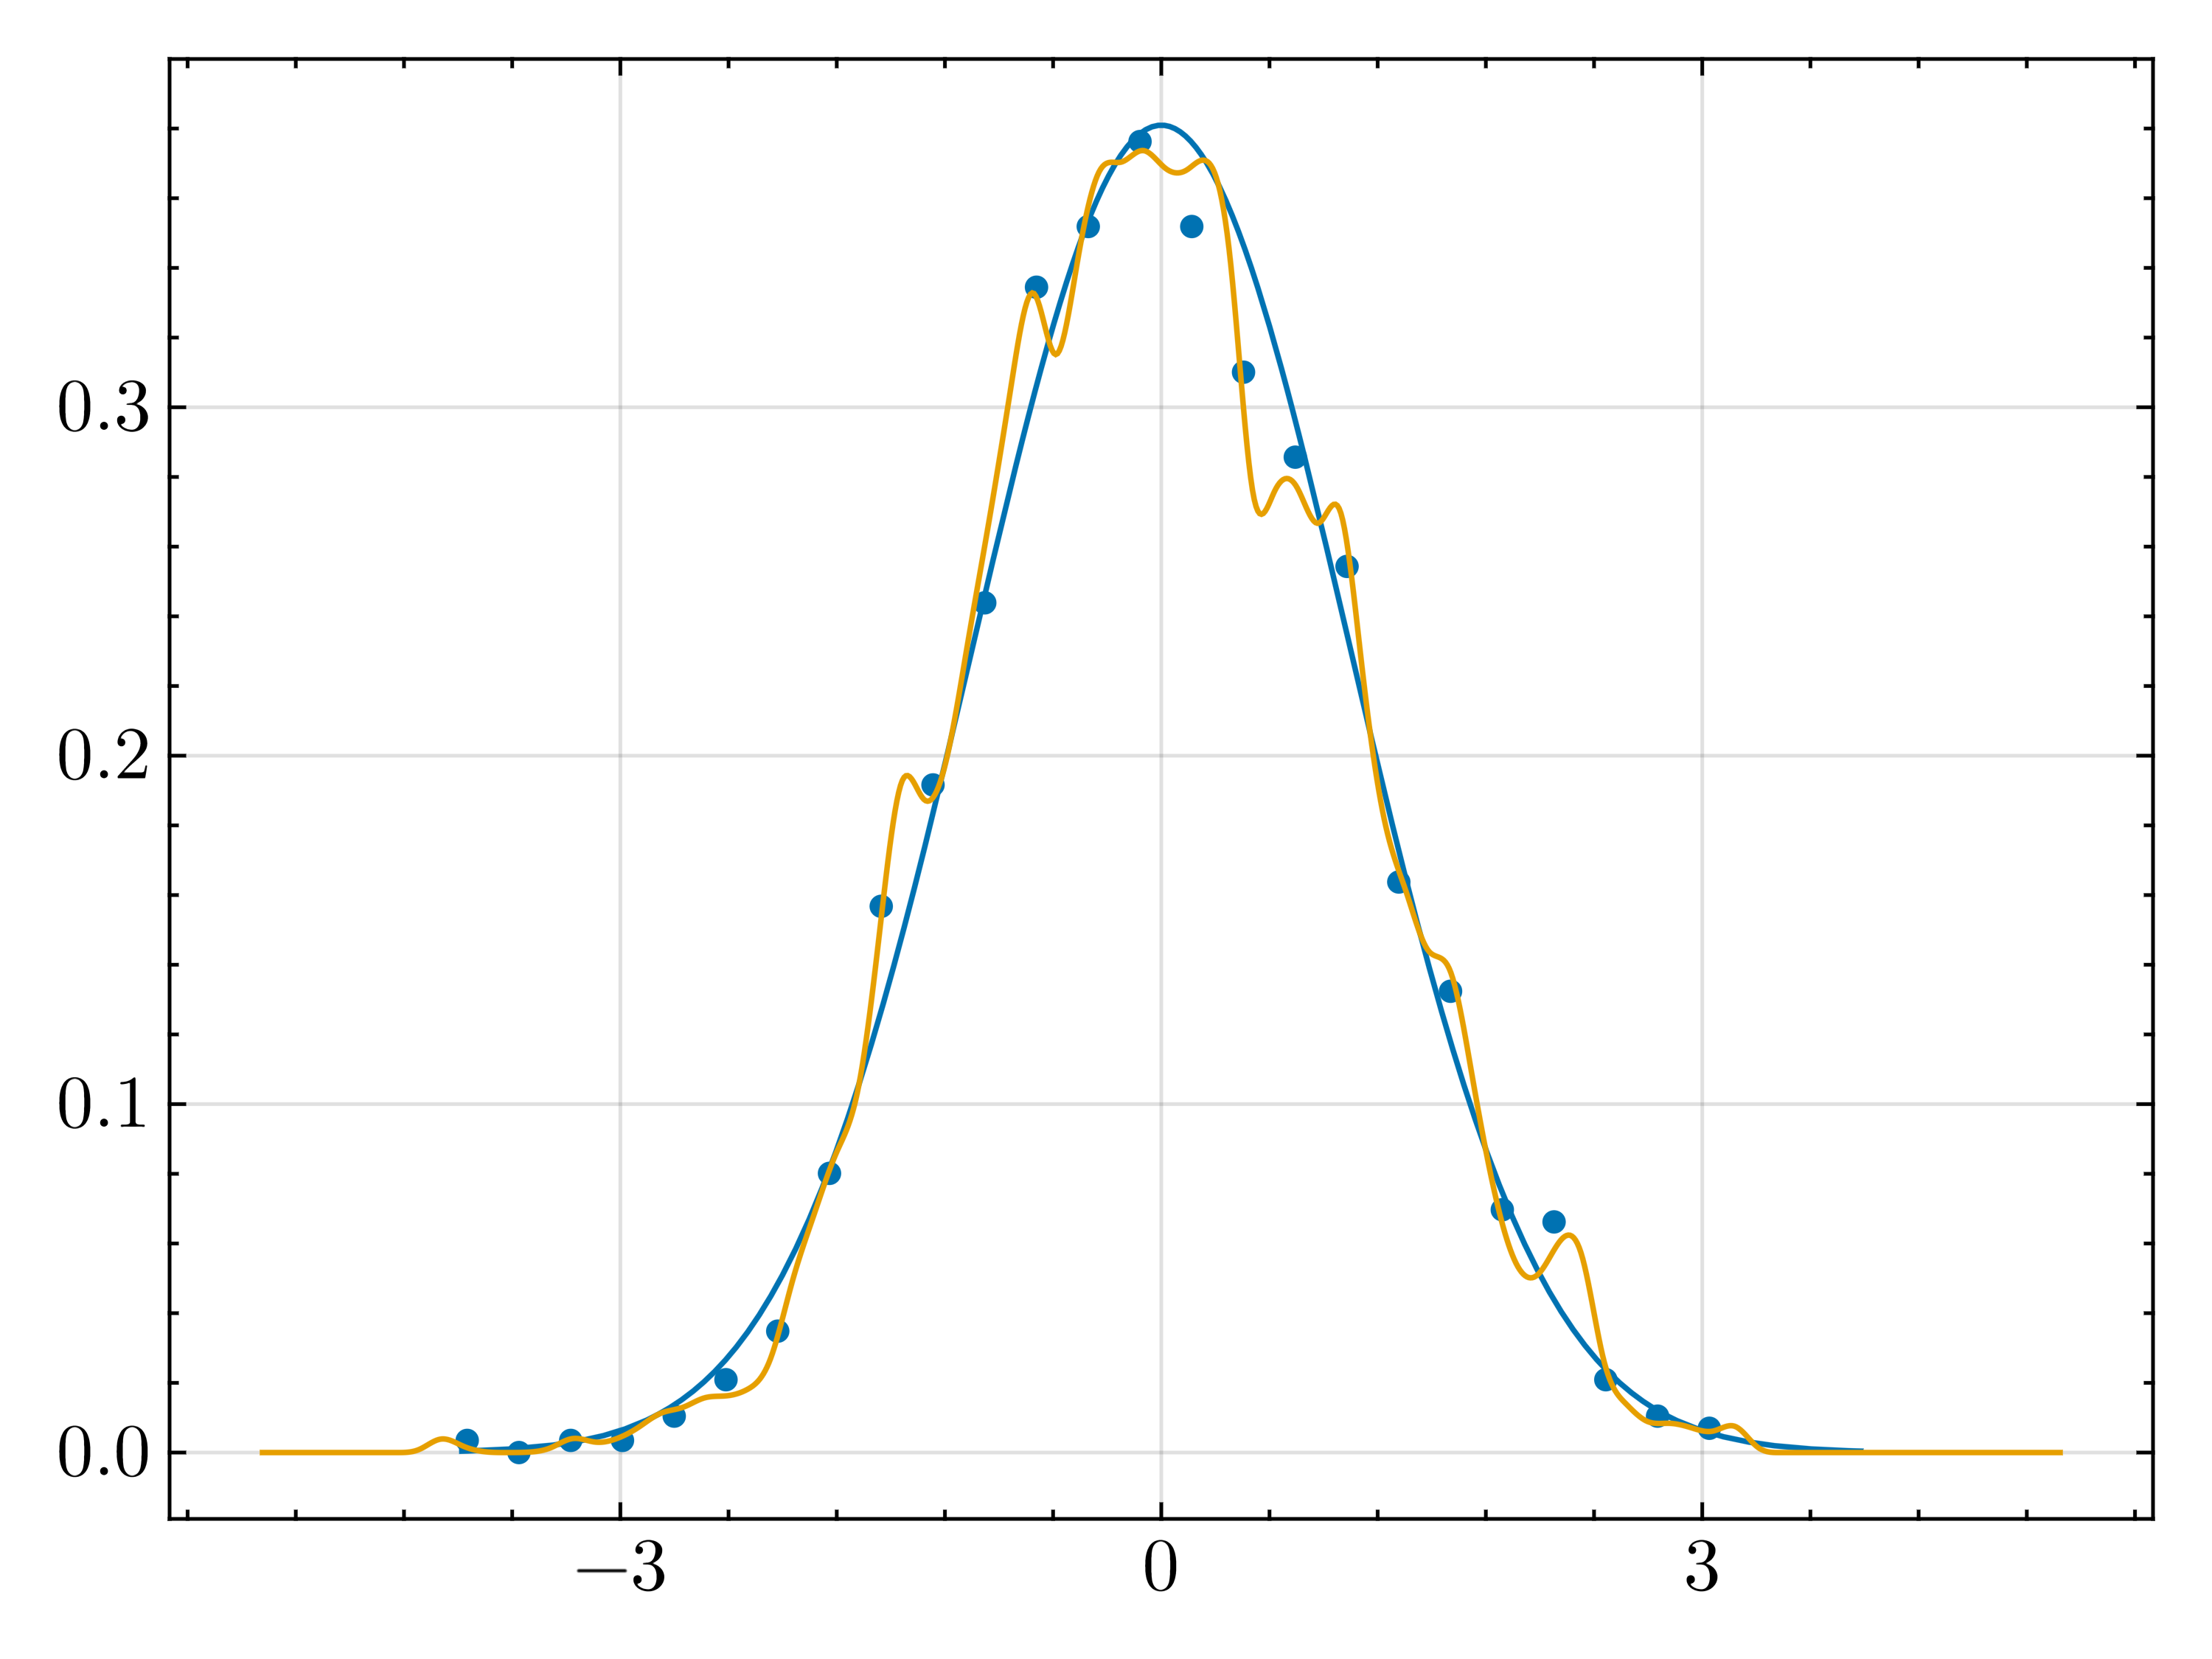

In [21]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

plot!(dist_normal)

x_m = LinRange(-5, 5, 1000)
y = s.(x_m)
lines!(x_m, y)

fig

## Series approximated duals

In [22]:
function log_L(spline::DE.BSpline, x)
    N = length(x)
    s_x = spline.(x)
    
    if any(s_x .< 0)
        println("minimum: ", minimum(s_x))
        println("x ", x[argmin(s_x)])
        println(" test, ", spline(x[argmin(s_x)]))

        
        println(DE.eval_spline(DE.knots_of(spline), DE.coefficients_of(spline), DE.order_of(spline), x[argmin(s_x)]))
        println(spline)
    end
    return 1/N * sum(log.(s_x))
end

log_L (generic function with 1 method)

In [23]:
function log_prior(spline)
    return 0
end

log_prior (generic function with 1 method)

In [24]:
function optimize_spline(knots, coef_i, order, samples)
    k2 = DE.pad_knots(knots, order)
    
    function ϕ(k)
        return DE.bspline_basis.([k2], k, order, samples)
    end
    
    Nc = length(coef_i) + 1
    c = 1/(knots[Nc+order] - knots[Nc]) * [knots[i+order] - knots[i] for i in 1:(Nc-1)]

    B = [(ϕ(k)-c[k]*ϕ(Nc)) for k in 1:(Nc-1)]
    
    function fgh!(F, G, H, coef)
        s = DE.normalized_spline(knots, coef, order)
        f =  DE.eval_spline(knots, DE.coefficients_of(s), order, samples)



        if G !== nothing
            for i in 1:length(coef)
                G[i] = sum(1 ./ f .* B[i])
            end 
        end

        if H !== nothing
            for i in 1:length(coef)
                for j in 1:length(coef)
                    H[i, j] = sum(- 1 ./ f .^2 .* ϕs[i] .* ϕs[j])
                end
            end 
        end
        
        if F !== nothing
            if any(DE.coefficients_of(s) .< 0) #|| any(f .< 0)
                return Inf
            end
            if any(f .< 0)
                println(DE.coefficients_of(s))
                println(coef)
                println("minimum", minimum(f))
                println("x ", samples[argmin(f)])
            end
            return -1/N * sum(log.(f))
        end
    end

    result = optimize(Optim.only_fgh!(fgh!), coef_i, BFGS())
    
    return result.minimizer, result
end

optimize_spline (generic function with 1 method)

In [35]:
Nk = 20
k_0 = quantile(x, LinRange(0, 1, Nk))
k_0 = LinRange(minimum(x), maximum(x), Nk)
k_0 = DE.pad_knots(k_0, order)
c0_0 = 1

1

In [36]:
s_primal = DE.PrimalBSpline(x, k_0, order=order)
a_0 = DE.coefficients_of(s_primal)

20-element Vector{Float64}:
 0.0017659717903704497
 0.0009079494663352788
 0.003055541113946152
 0.008619325151370127
 0.016738114152543972
 0.043429641406814636
 0.10806301010013125
 0.18574801114568557
 0.26220868220264015
 0.32882186521364887
 0.3640238441002556
 0.35909034630755743
 0.300369712938892
 0.25573493487533444
 0.18249809221748503
 0.11427097370754477
 0.062371394890906894
 0.03472622013367938
 0.010280822050146798
 0.005046019330493912

In [37]:
DE.normalized_spline(k_0, a_0[1:end-1], order)

DensityEstimators.BSpline([-4.748297670794583, -4.370621429419726, -3.9929451880448705, -3.6152689466700143, -3.2375927052951576, -2.8599164639203005, -2.4822402225454443, -2.104563981170588, -1.7268877397957314, -1.3492114984208747  …  0.539169708453408, 0.9168459498282646, 1.294522191203121, 1.6721984325779777, 2.049874673952834, 2.427550915327691, 2.8052271567025473, 3.182903398077404, 3.5605796394522606, 3.9382558808271173], [0.0017659717903704497, 0.0009079494663352788, 0.003055541113946152, 0.008619325151370127, 0.016738114152543972, 0.043429641406814636, 0.10806301010013125, 0.18574801114568557, 0.26220868220264015, 0.32882186521364887, 0.3640238441002556, 0.35909034630755743, 0.300369712938892, 0.25573493487533444, 0.18249809221748503, 0.11427097370754477, 0.062371394890906894, 0.03472622013367938, 0.010280822050146798, 0.0050460193304936955], 4)

In [38]:
a1 = [0.000155927, 0.000274519, 0.00277876, 0.00976625, 0.0256756, 0.055563, 0.113037, 0.197492, 0.285299, 0.349735, 0.367316, 0.327223, 0.255598, 0.163475, 0.082927, 0.036096, 0.0135062, 0.00506174, 0.00127557, 9.75673e-6]
k1 = [-5.131925027797792, -4.695675337311014, -4.259425646824236, -3.823175956337458, -3.38692626585068, -2.950676575363902, -2.5144268848771243, -2.0781771943903458, -1.641927503903568, -1.2056778134167894, -0.7694281229300117, -0.3331784324432341, 0.10307125804354467, 0.5393209485303228, 0.9755706390171006, 1.4118203295038794, 1.8480700199906566, 2.284319710477435, 2.7205694009642127, 3.1568190914509913, 3.593068781937769, 4.029318472424547, 4.465568162911326, 4.9018178533981045]

24-element Vector{Float64}:
 -5.131925027797792
 -4.695675337311014
 -4.259425646824236
 -3.823175956337458
 -3.38692626585068
 -2.950676575363902
 -2.5144268848771243
 -2.0781771943903458
 -1.641927503903568
 -1.2056778134167894
 -0.7694281229300117
 -0.3331784324432341
  0.10307125804354467
  0.5393209485303228
  0.9755706390171006
  1.4118203295038794
  1.8480700199906566
  2.284319710477435
  2.7205694009642127
  3.1568190914509913
  3.593068781937769
  4.029318472424547
  4.465568162911326
  4.9018178533981045

In [39]:
DE.BSpline(k1, a1, 4).(4.029318472424547)
#DE.eval_spline(k1, a1, 4, 4.029318472424547)

0.00021909948666666703

In [40]:
a, result = optimize_spline(k_0, a_0[1:end-1], order, x)
result

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.464064e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.93e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.08e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.46e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.00e-06 ≰ 0.0e+00
    |g(x)|                 = 3.28e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    64888
    ∇f(x) calls:   64888


In [41]:
s_best = DE.normalized_spline(k_0, a, order)

DensityEstimators.BSpline([-4.748297670794583, -4.370621429419726, -3.9929451880448705, -3.6152689466700143, -3.2375927052951576, -2.8599164639203005, -2.4822402225454443, -2.104563981170588, -1.7268877397957314, -1.3492114984208747  …  0.539169708453408, 0.9168459498282646, 1.294522191203121, 1.6721984325779777, 2.049874673952834, 2.427550915327691, 2.8052271567025473, 3.182903398077404, 3.5605796394522606, 3.9382558808271173], [0.006448936959051867, 0.004053234973249631, 0.0015877858747689075, 0.01104281943640178, 0.017831249630846466, 0.043515387446051365, 0.10842888675521506, 0.18640490014159938, 0.26182072351505015, 0.3279949388355993, 0.36318327266748246, 0.35811290739730306, 0.2993630983796335, 0.25468949209153796, 0.181743751829821, 0.11329678392581254, 0.061635471371369745, 0.03428359357655799, 0.009887288923951824, 0.0024459485644786763], 4)

In [42]:
DE.area_of(s_best)

1.0

In [43]:
h = DE.histogram(x, normalization=:pdf)
length(h.bins), length(h.values)

(26, 25)

TODO: apply constraints to assert all a>0, look into how to handle the boundaries (maybe reducing degrees of freedom)
and apply constraint for normalization?
Need analytic derivatives and hessian


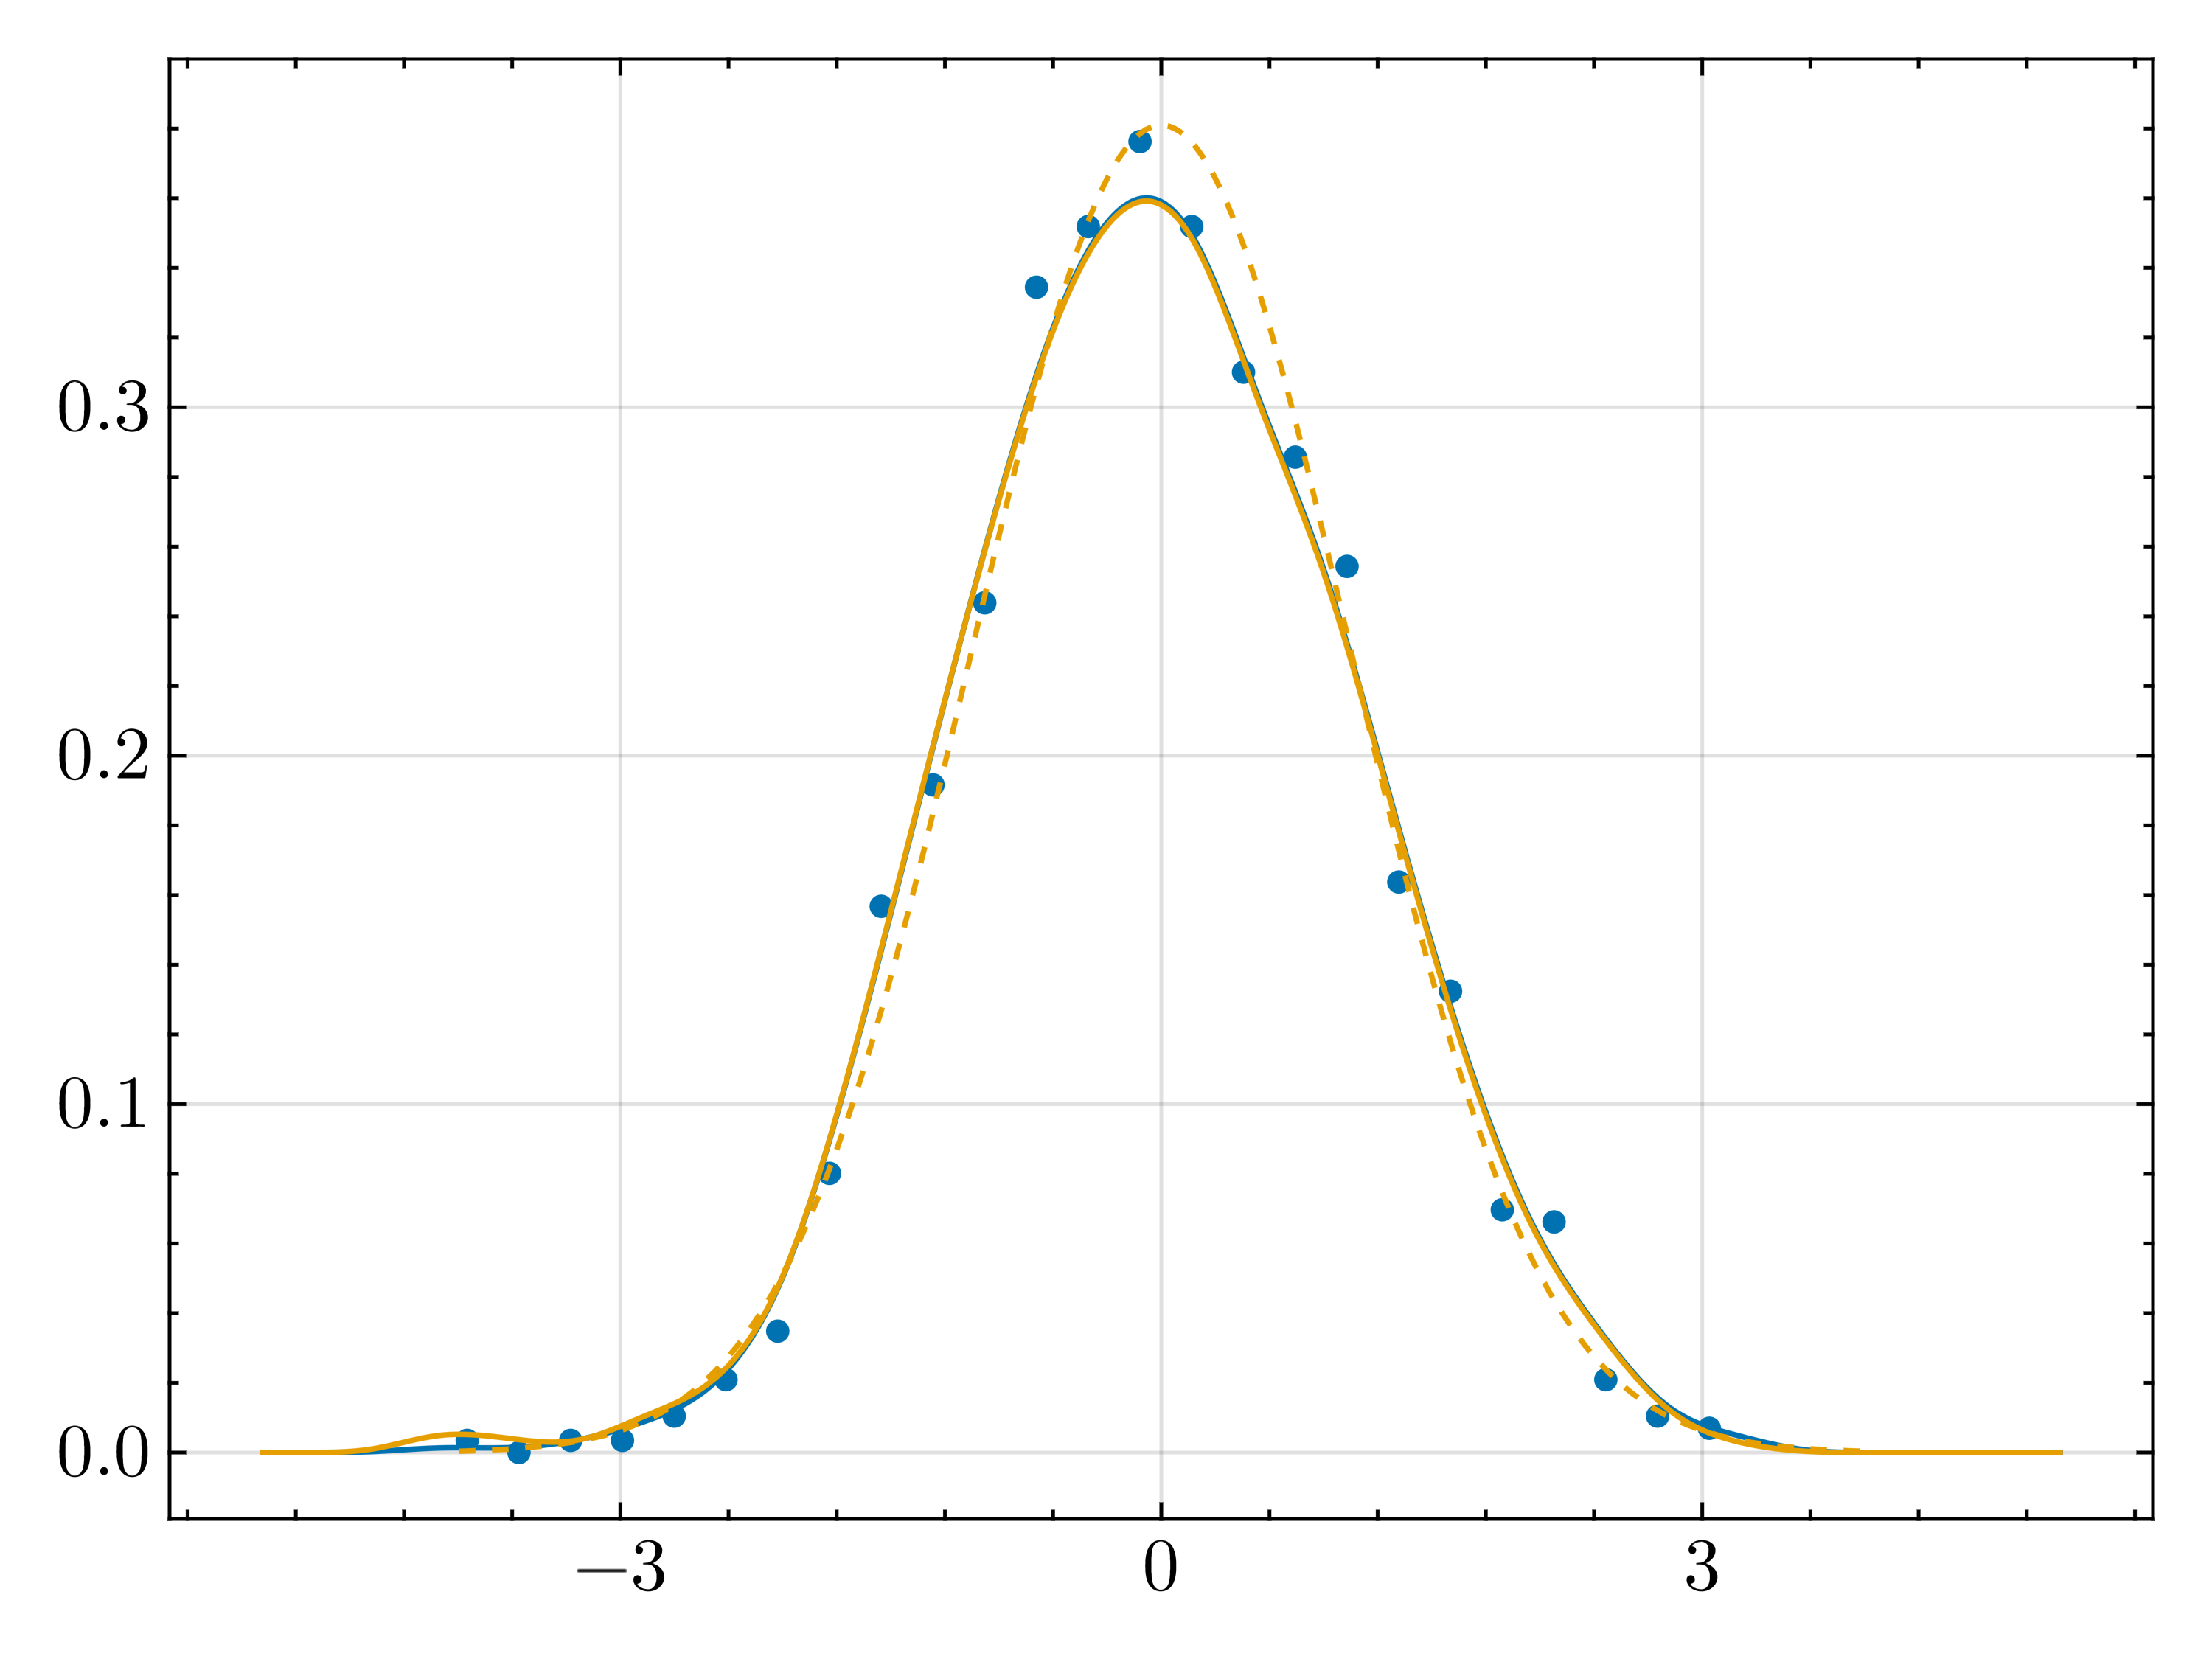

In [44]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

x_m = LinRange(-5, 5, 1000)
y_m = s_primal.(x_m)
lines!(x_m, y_m)

y_m = s_best.(x_m)
lines!(x_m, y_m)
lines!(dist_normal, color=COLORS[2], linestyle=:dash)

fig

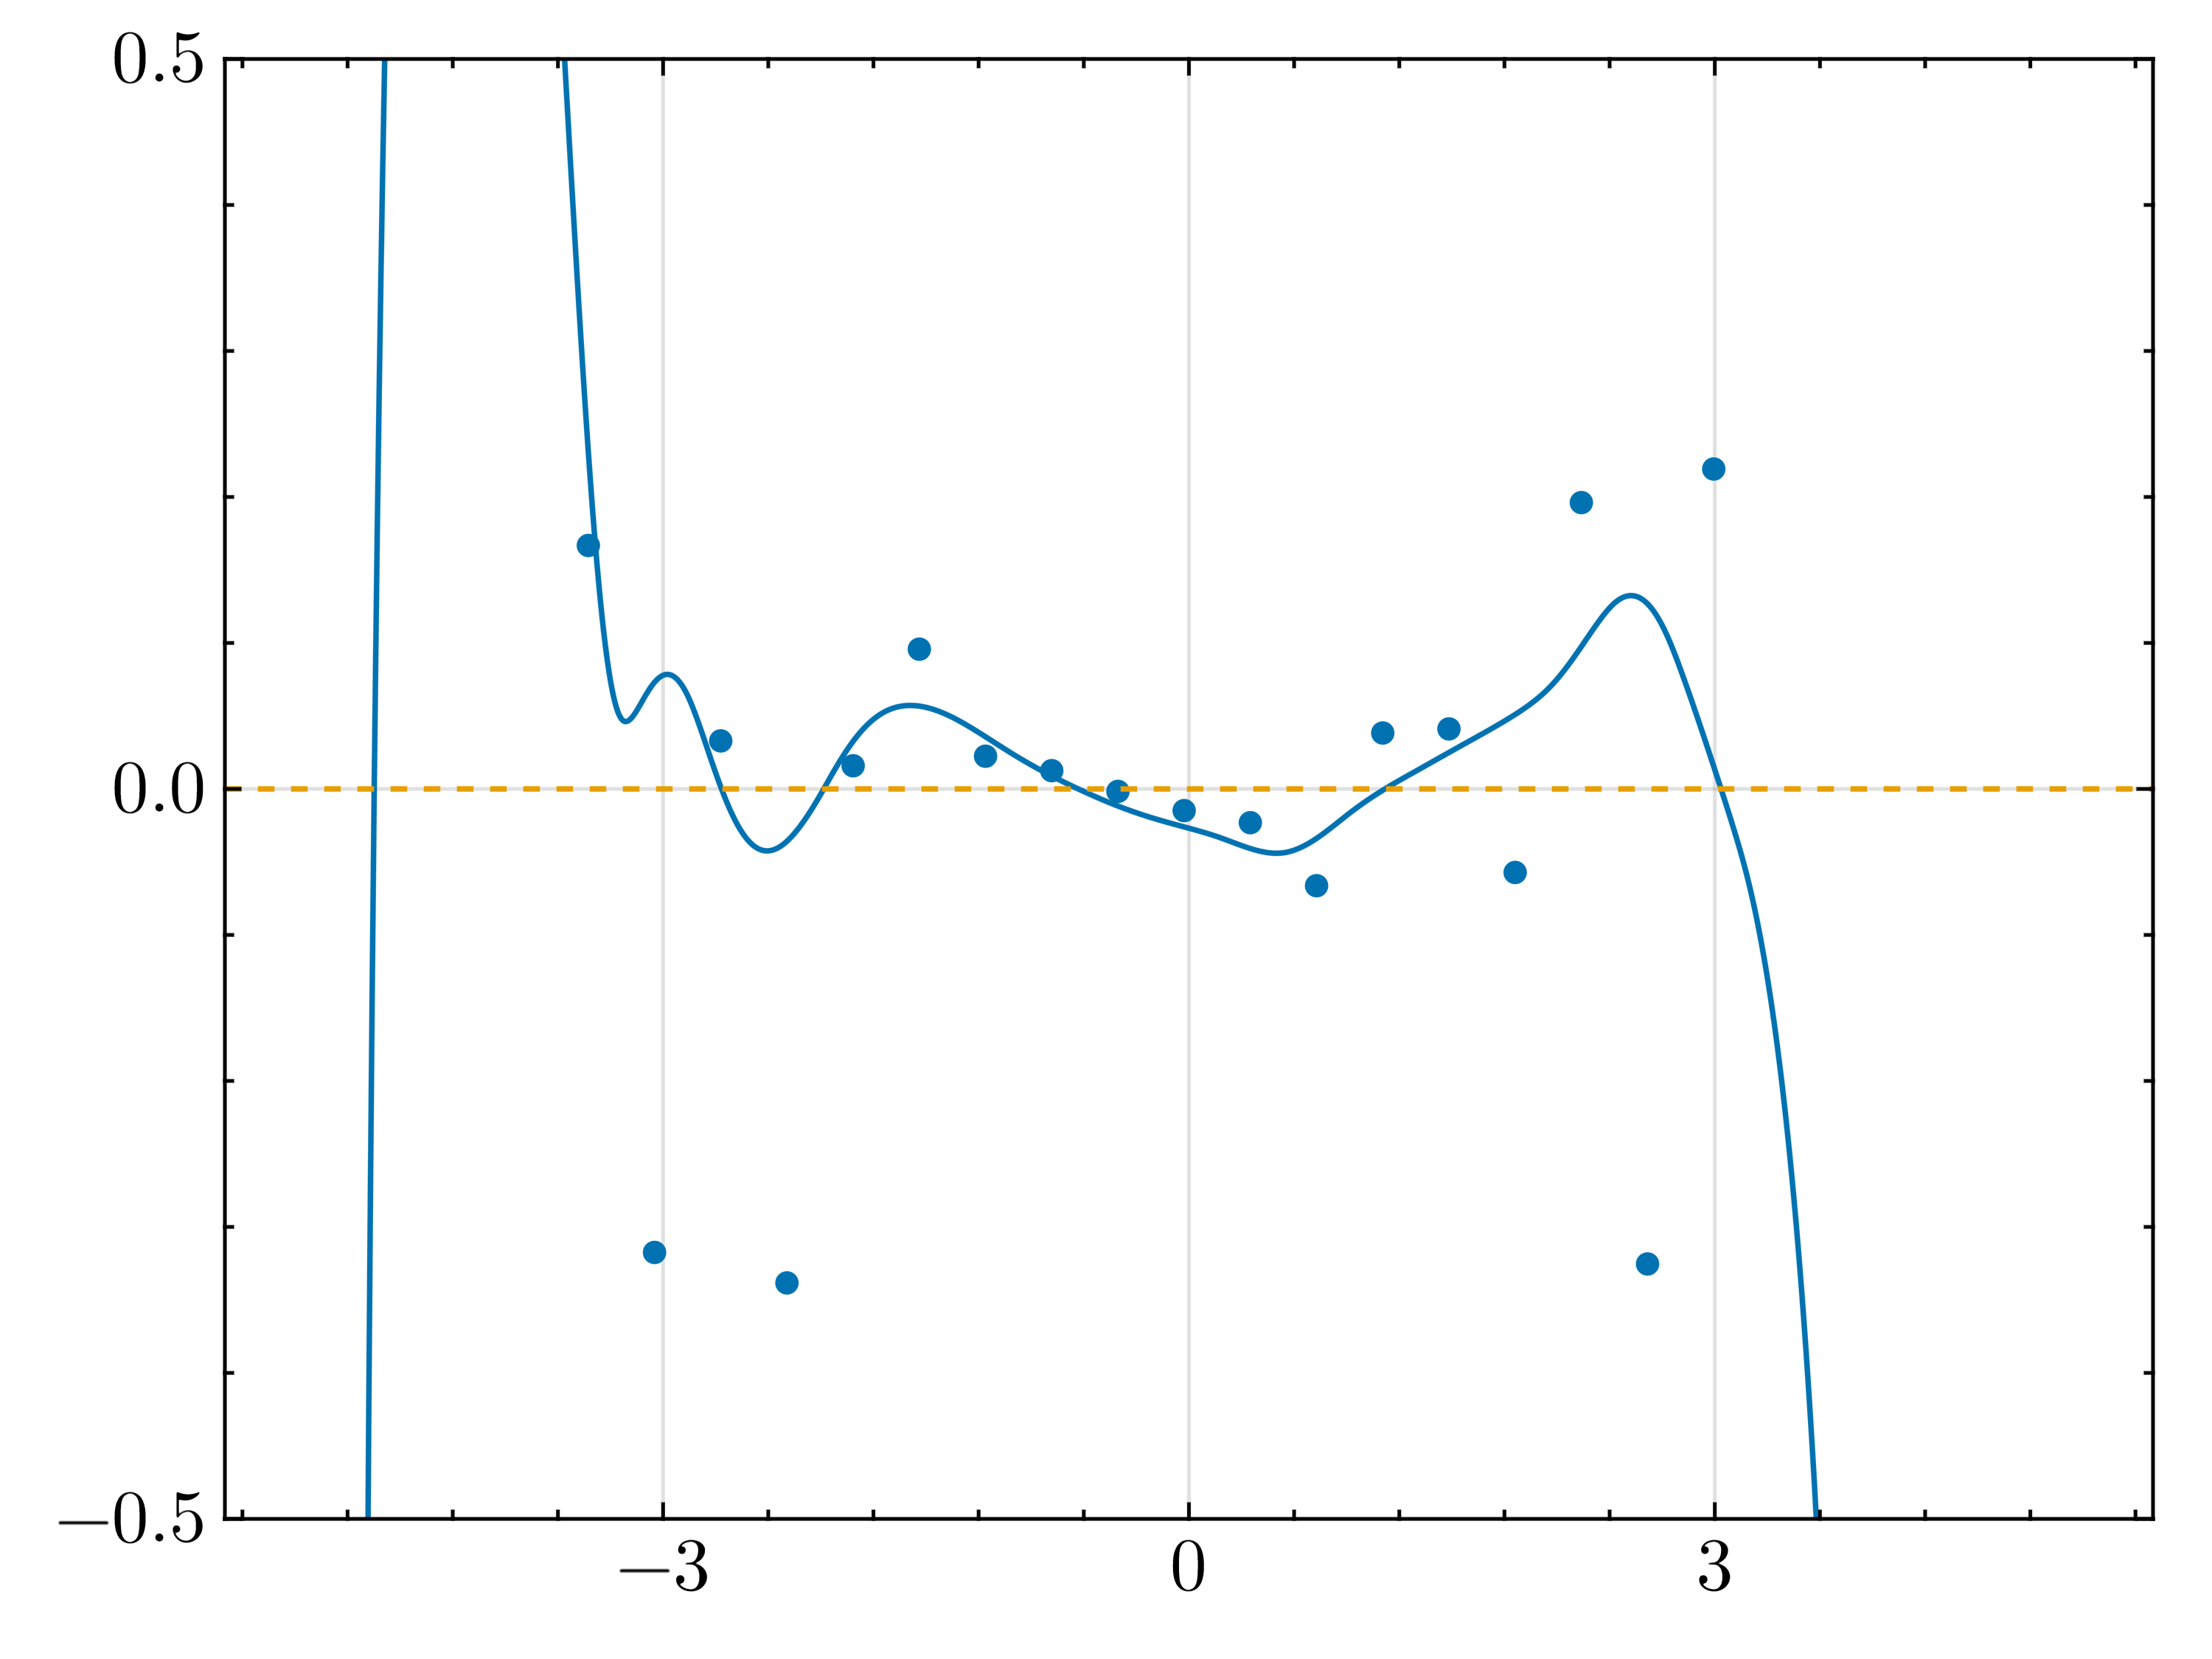

In [45]:
fig, ax = FigAxis(
limits=(nothing, (-0.5, 0.5))
    )

h = DE.histogram(x, Nk-1, normalization=:pdf)
y_h = log10.(h.values ./ pdf.(dist_normal, midpoints(h.bins)))
plot!(midpoints(h.bins), y_h)

x_m = LinRange(-5, 5, 1000)
y_m = log10.(s_best.(x_m) ./ pdf.(dist_normal, x_m))
lines!(x_m, y_m)

hlines!(0, color=COLORS[2], linestyle=:dash)

fig

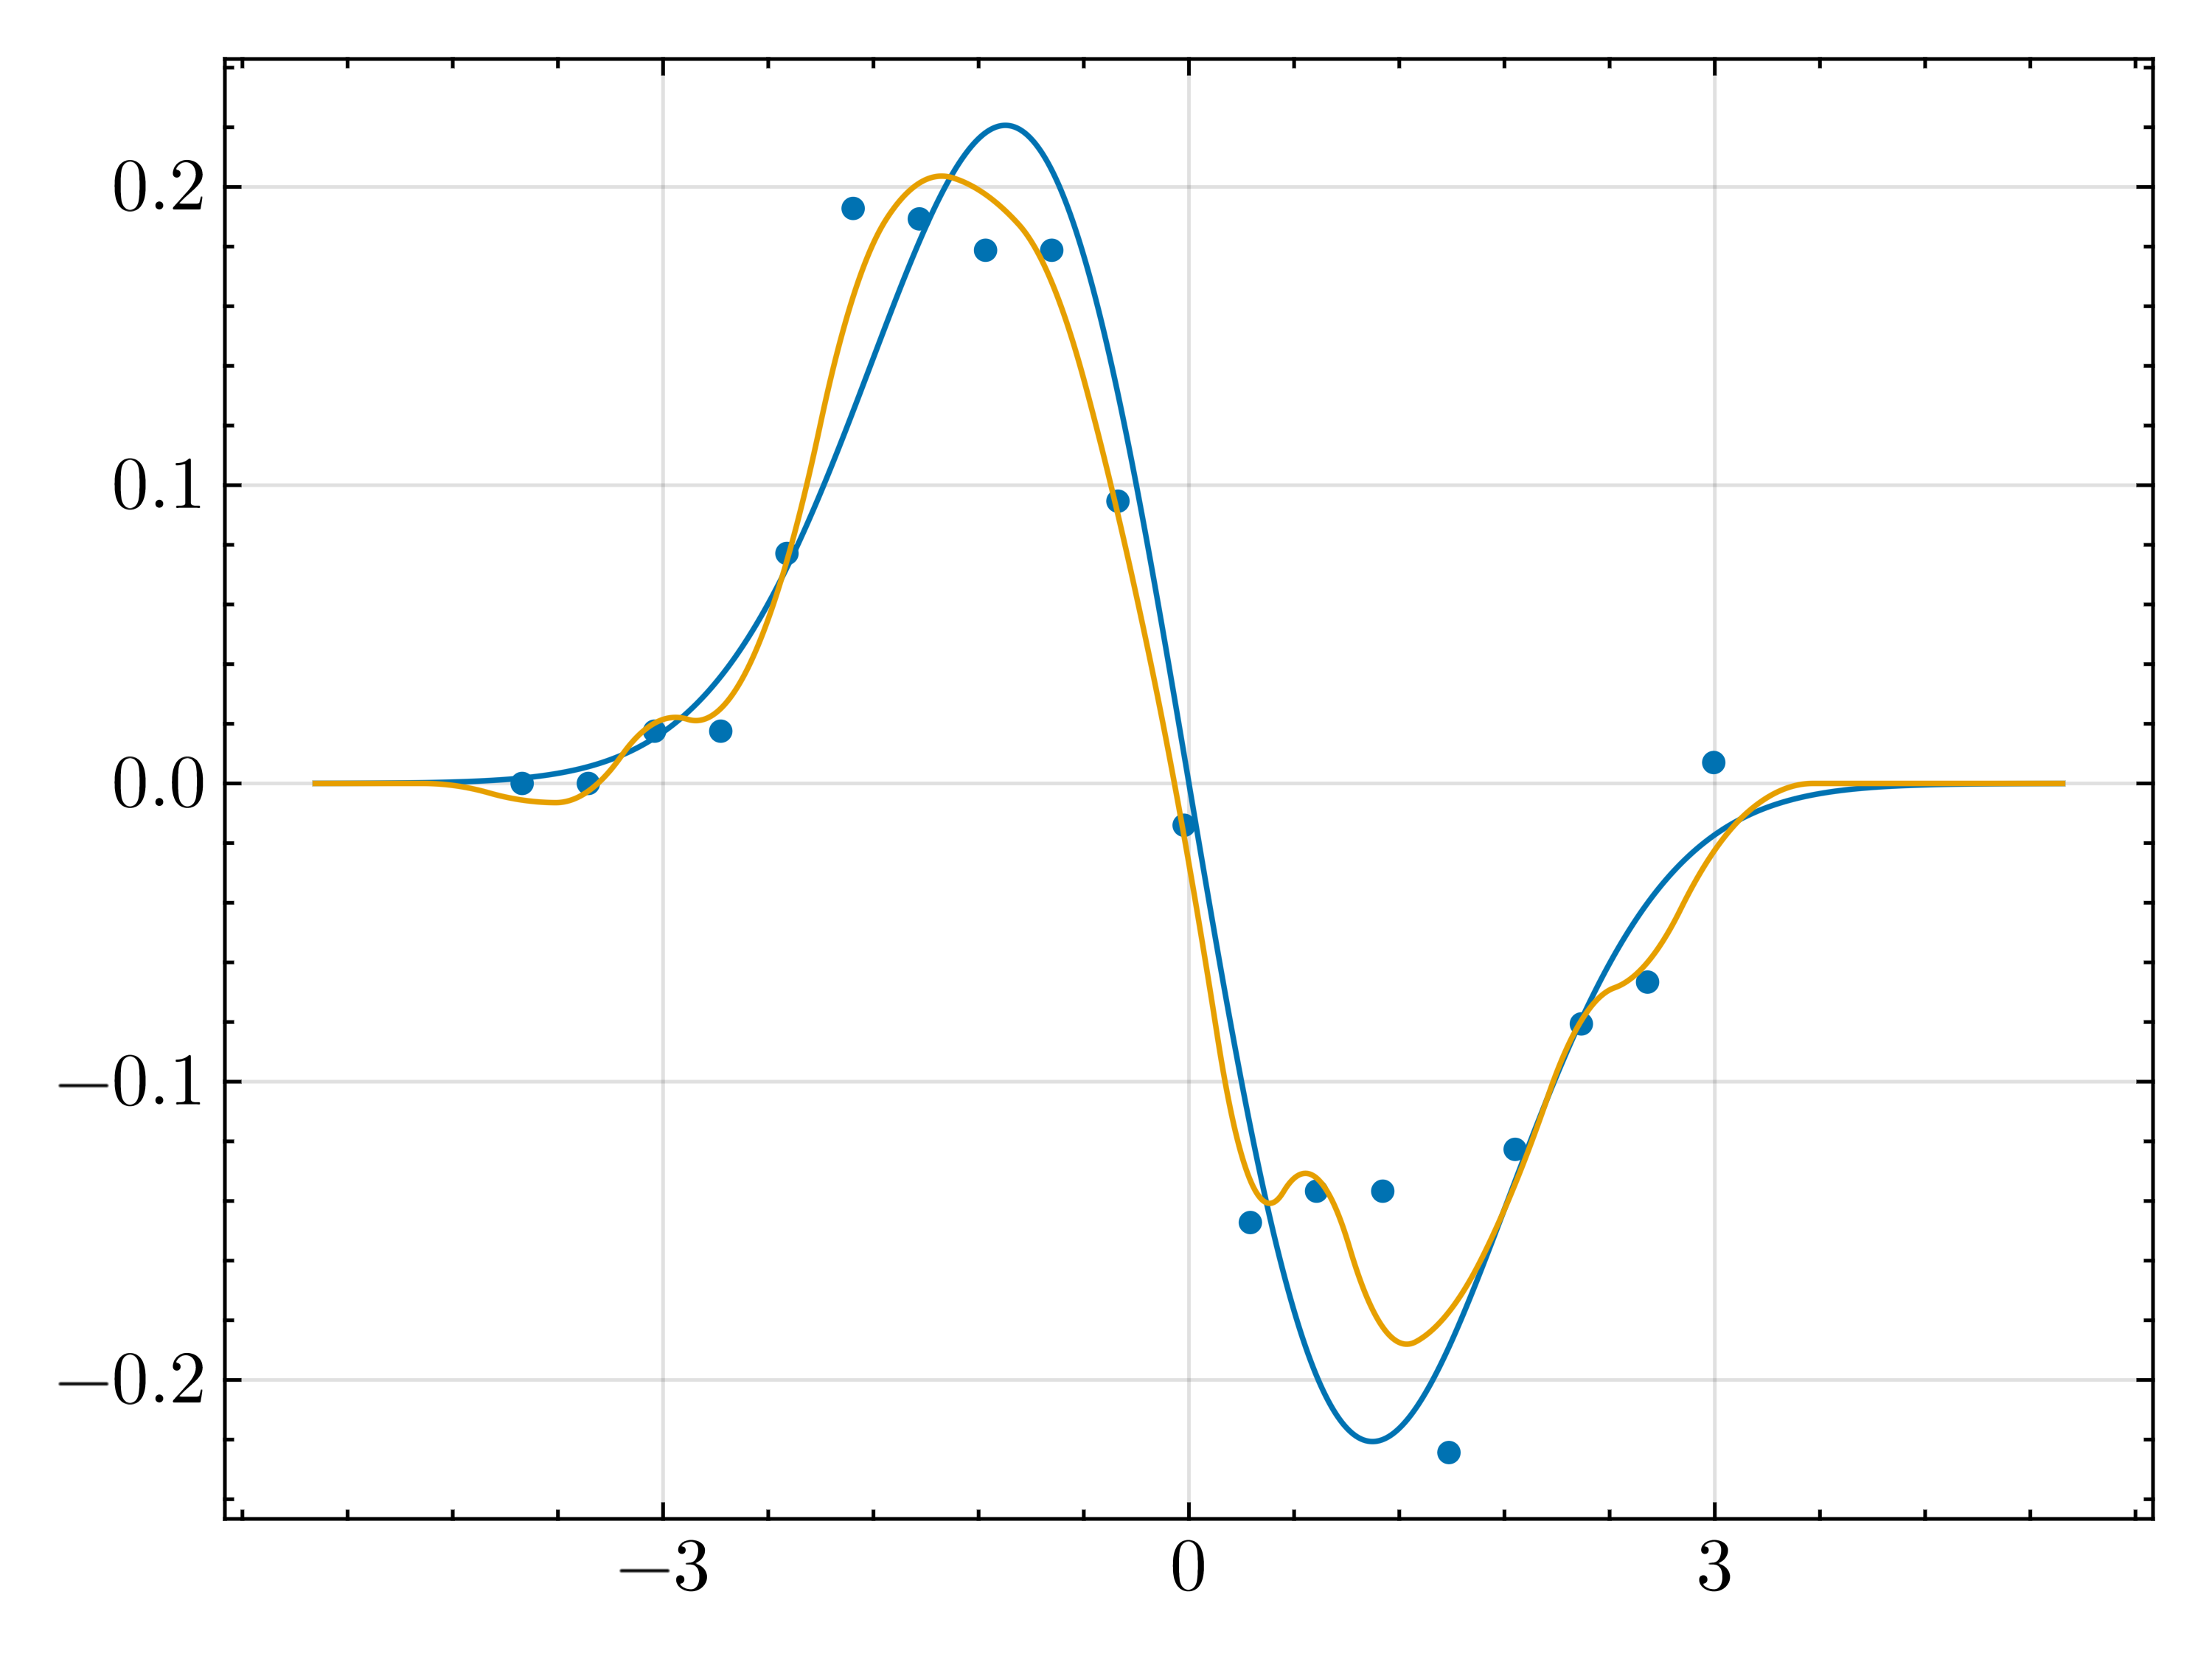

In [51]:
fig, ax = FigAxis()

x_h = midpoints(h.bins)
y_h = h.values

plot!(x_h, DE.gradient(y_h, x_h))
plot_derivative!(dist_normal)

y_m = DE.derivative(s_best).(x_m)

lines!(x_m, y_m)

fig

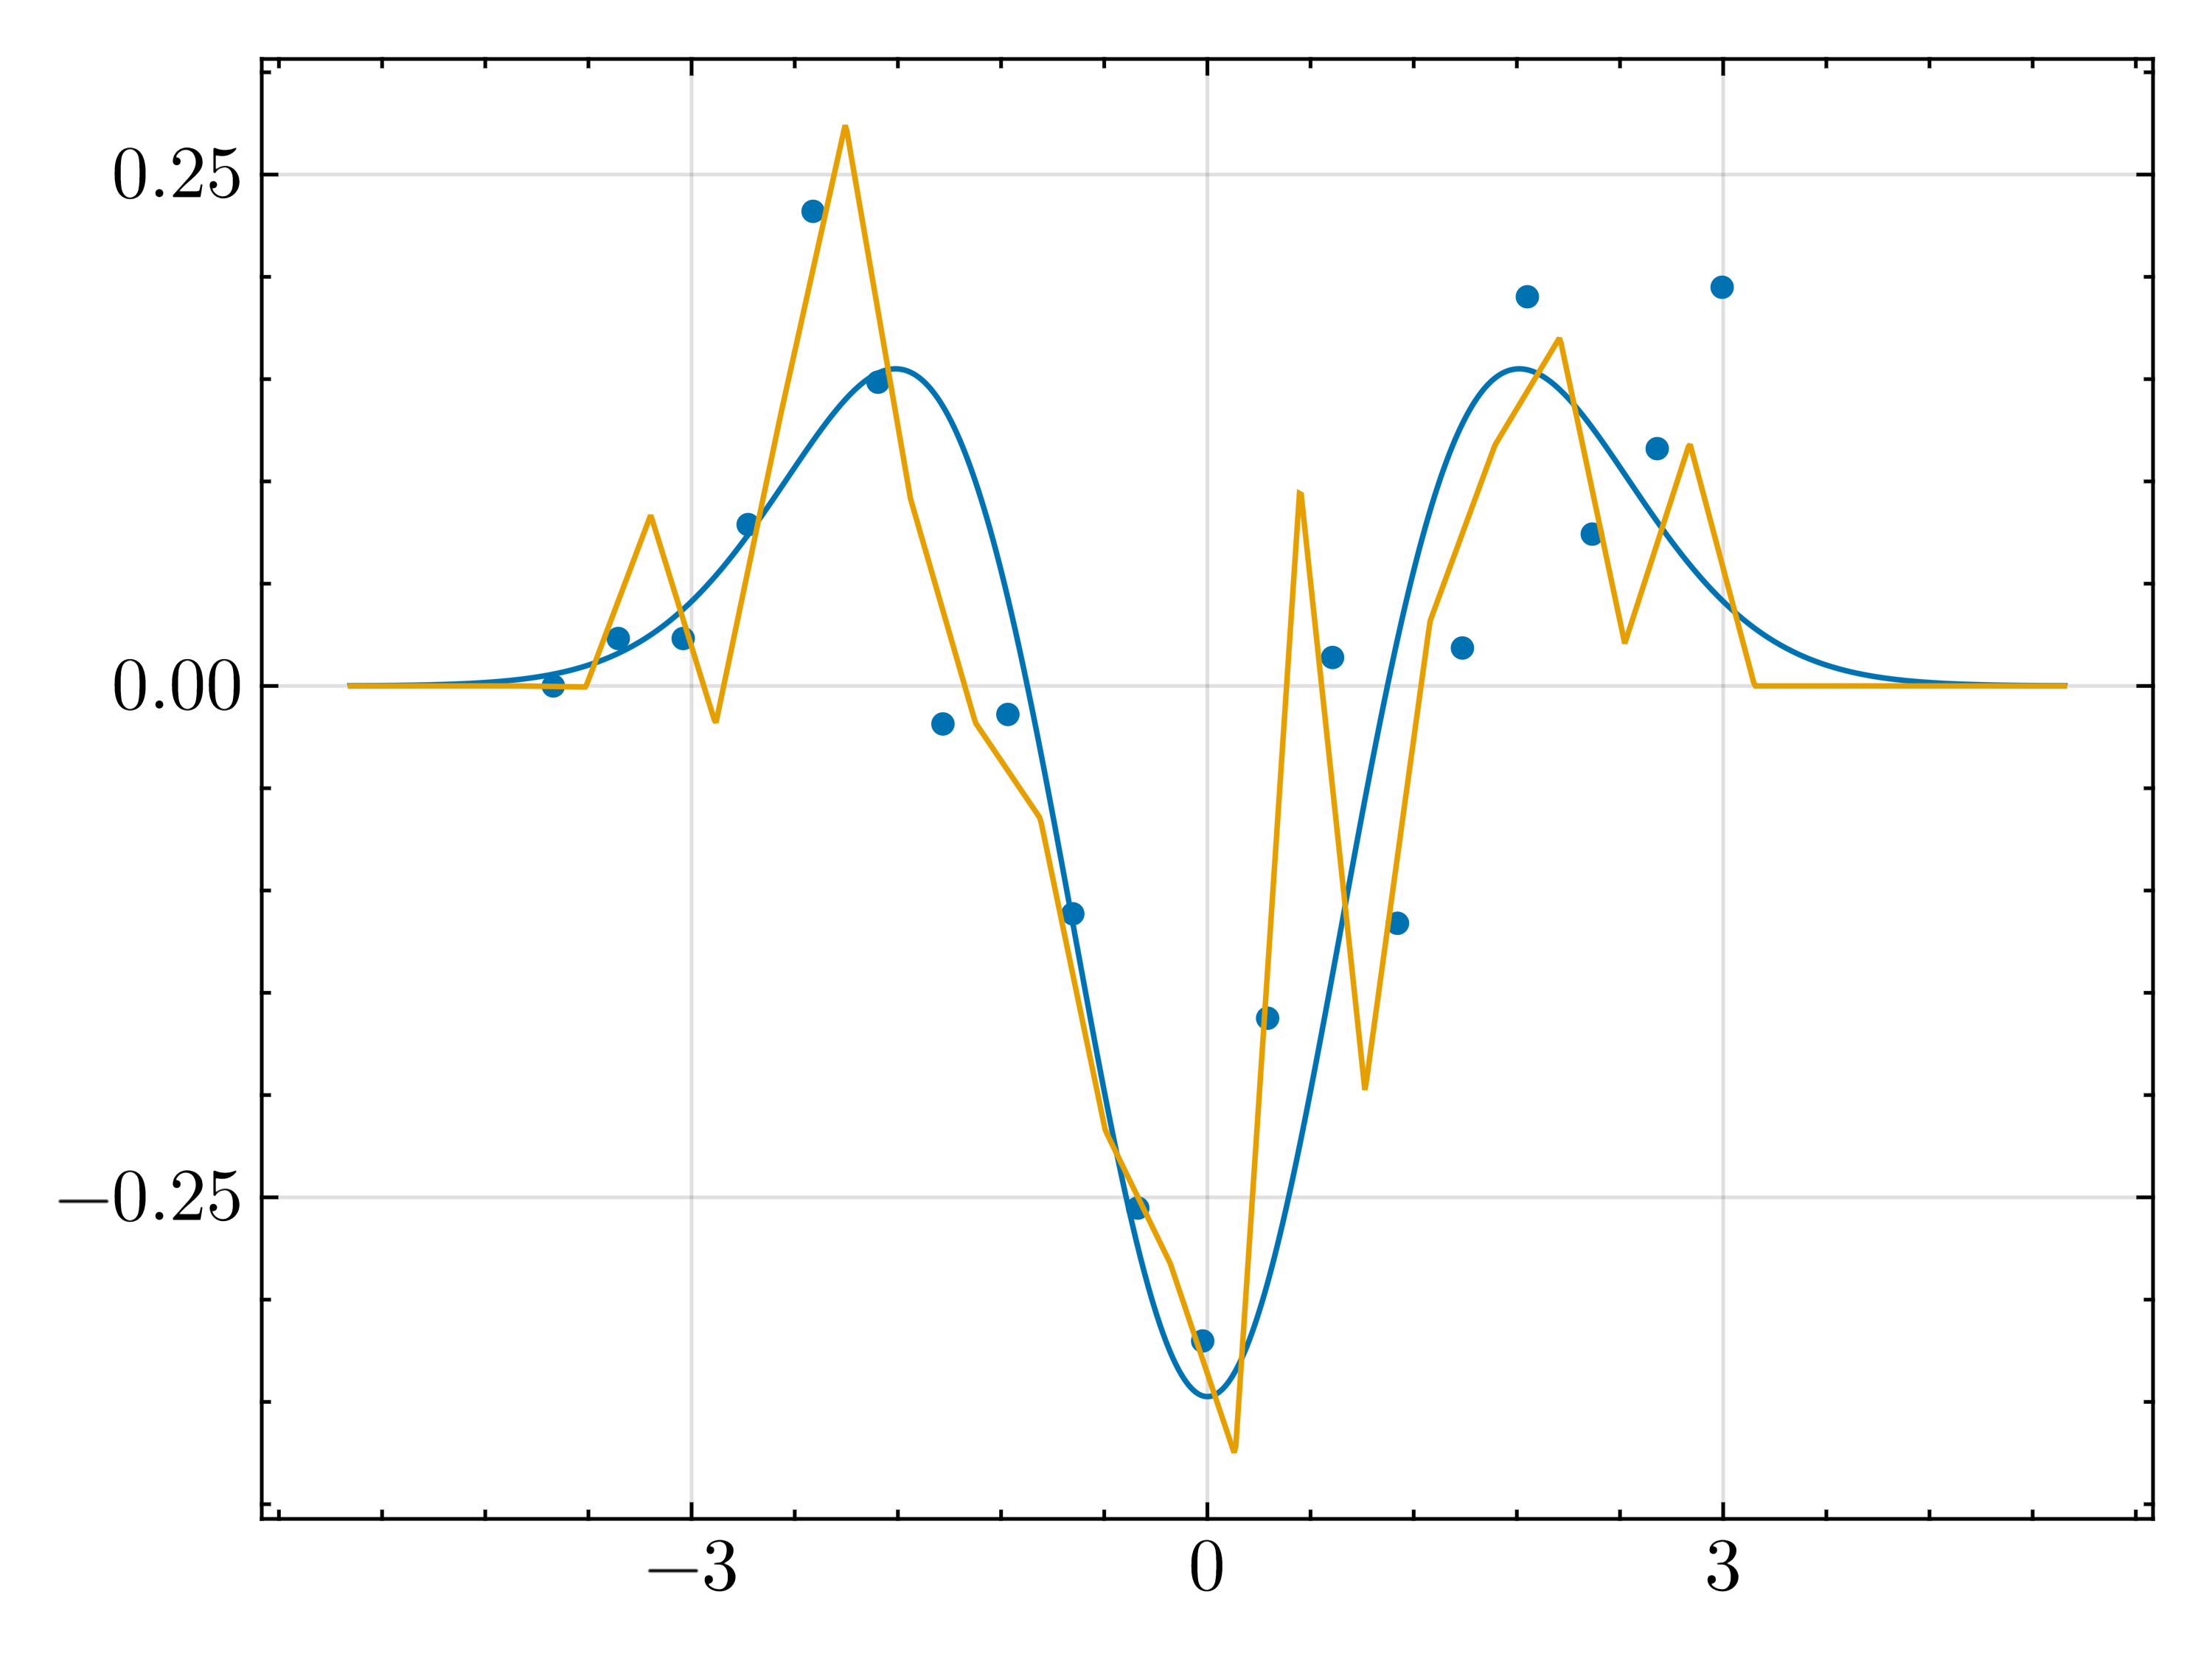

In [52]:
fig, ax = FigAxis()

plot!(x_h, DE.gradient(DE.gradient(y_h, x_h), x_h))
plot_d2!(dist_normal)

y_m = DE.derivative(s_best, 2).(x_m)

lines!(x_m, y_m)

fig

# Log Splines

In [53]:
struct LogSpline
    knots::Vector{Float64}
    coef::Vector{Float64}
    order::Int
    _spline
    _norm
end

In [54]:
function LogSpline(knots, coefs, order=3)
    s = DE.BSpline(knots, coefs, order)
    
    spline_unnorm = LogSpline(knots, coefs, order, s, 1) 
    A = quadgk(spline_unnorm, knots[1], knots[end])[1]
    
    return LogSpline(knots, coefs, order, s, 1/A)
end

LogSpline

In [55]:
function log_L(spline::LogSpline, x; s=0.0)
    N = length(x)
    s_x = spline.(x)
    if any(s_x .< 0)
        return -Inf
    end
    
    A = quadgk(spline, spline.knots[1], spline.knots[end])[1]
    
    return 1/N * sum(log.(s_x)) - 3abs.(log.(A)) # constraint
end

log_L (generic function with 2 methods)

In [56]:
function optimize_lspline(knots, coef_i, order, samples)
    
    function obj(coef)
        s = LogSpline(knots, coef, order)
        -log_L(s, samples)
    end
    
    result = optimize(obj, coef_i)
    
    return result.minimizer, result
end

optimize_lspline (generic function with 1 method)

In [57]:
function (s::LogSpline)(x)
    return exp.(s._spline(x)) .* s._norm
end

In [61]:
Nk = 20
k_0 = LinRange(minimum(x), maximum(x), Nk)
#k_0 = quantile(x, LinRange(0, 1, Nk));

order = 4

4

In [62]:
a_0 = randn(Nk - order);

In [63]:
a, res = optimize_lspline(k_0, a_0, order, x)

([-5.158988798333604, 0.039555807635545816, -0.16475699223280288, 0.6548466819283343, 2.2180081134804386, 2.4861800533109277, 2.8672286597300083, 3.192293270902169, 3.1119852659751546, 3.425922907690563, 2.768886314248071, 3.0809333229485816, 2.4289856379118184, 1.9691800626054097, 1.6735893855630943, -0.16052797521888726],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.464072e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1323
)

In [66]:
s_best = LogSpline(k_0, a, order)

LogSpline([-3.9929451880448705, -3.6152689466700143, -3.2375927052951576, -2.8599164639203005, -2.4822402225454443, -2.104563981170588, -1.7268877397957314, -1.3492114984208747, -0.9715352570460181, -0.5938590156711618, -0.21618277429630517, 0.16149346707855172, 0.539169708453408, 0.9168459498282646, 1.294522191203121, 1.6721984325779777, 2.049874673952834, 2.427550915327691, 2.8052271567025473, 3.182903398077404], [-5.158988798333604, 0.039555807635545816, -0.16475699223280288, 0.6548466819283343, 2.2180081134804386, 2.4861800533109277, 2.8672286597300083, 3.192293270902169, 3.1119852659751546, 3.425922907690563, 2.768886314248071, 3.0809333229485816, 2.4289856379118184, 1.9691800626054097, 1.6735893855630943, -0.16052797521888726], 4, DensityEstimators.BSpline(LinRange{Float64}(-3.9929451880448705, 3.182903398077404, 20), [-5.158988798333604, 0.039555807635545816, -0.16475699223280288, 0.6548466819283343, 2.2180081134804386, 2.4861800533109277, 2.8672286597300083, 3.192293270902169, 

In [67]:
s_best._norm

0.014909566220506928

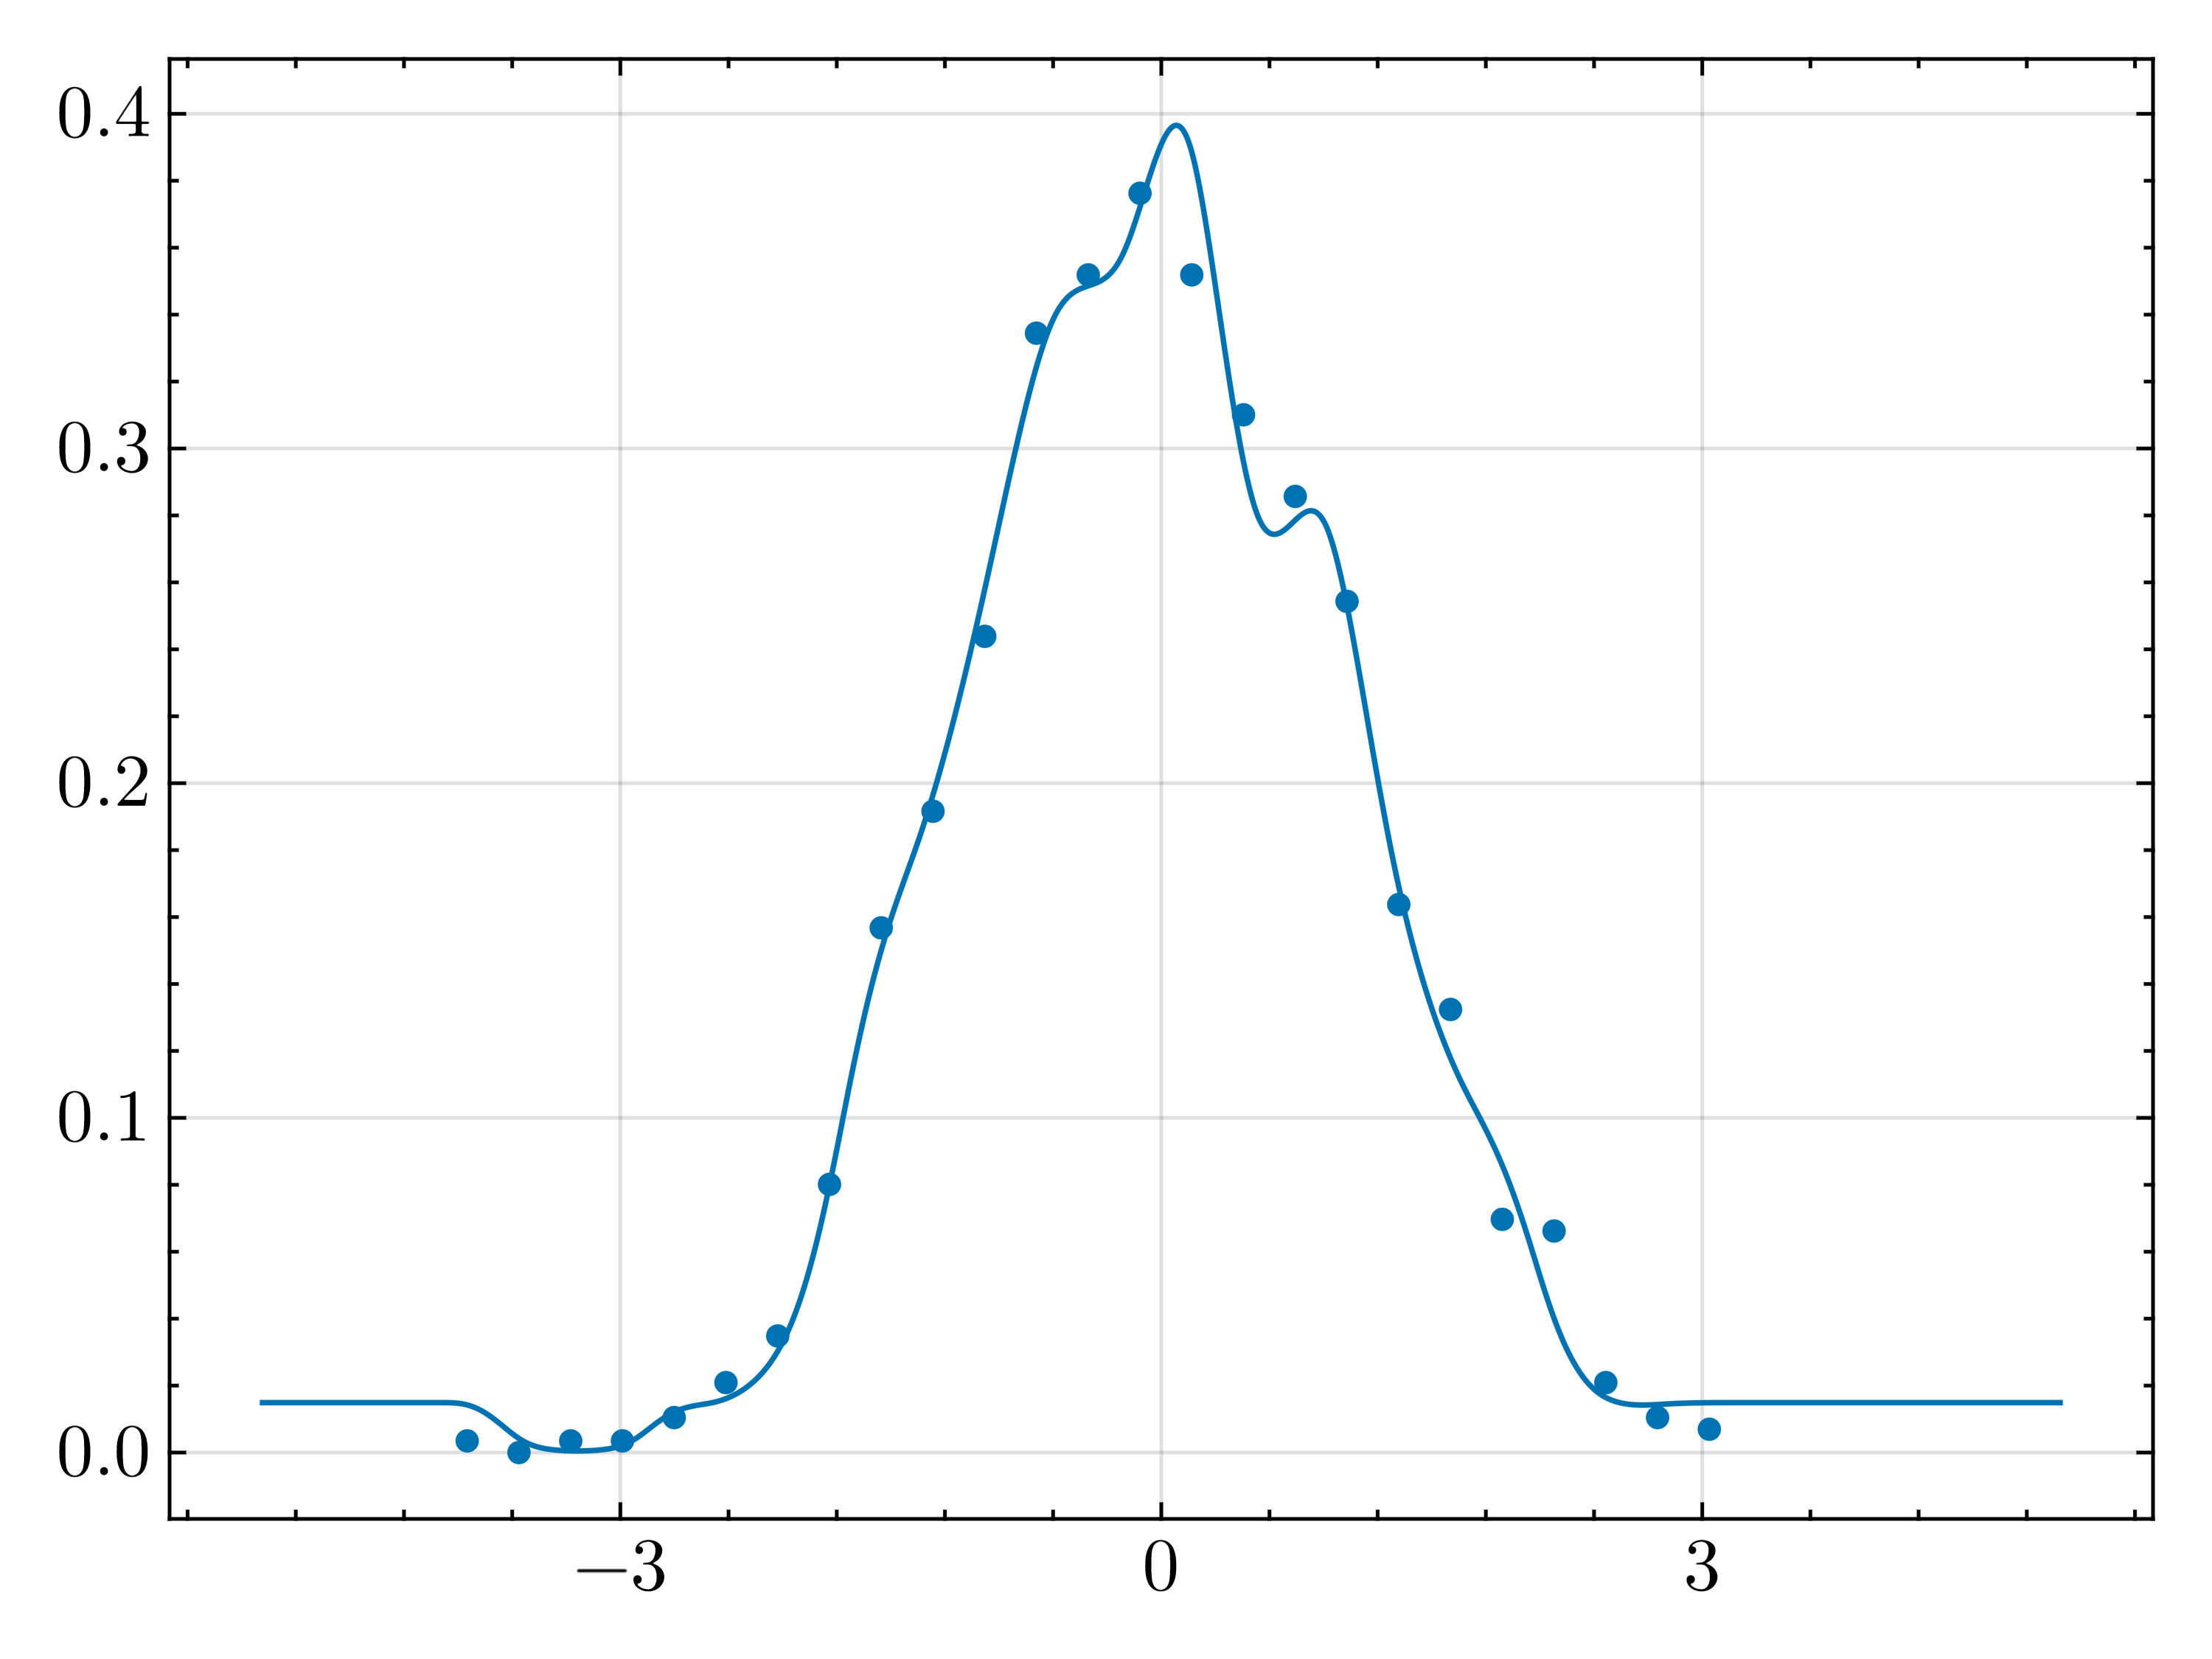

In [70]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
x_m = LinRange(-5, 5, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)

plot!(midpoints(h.bins), h.values)
fig

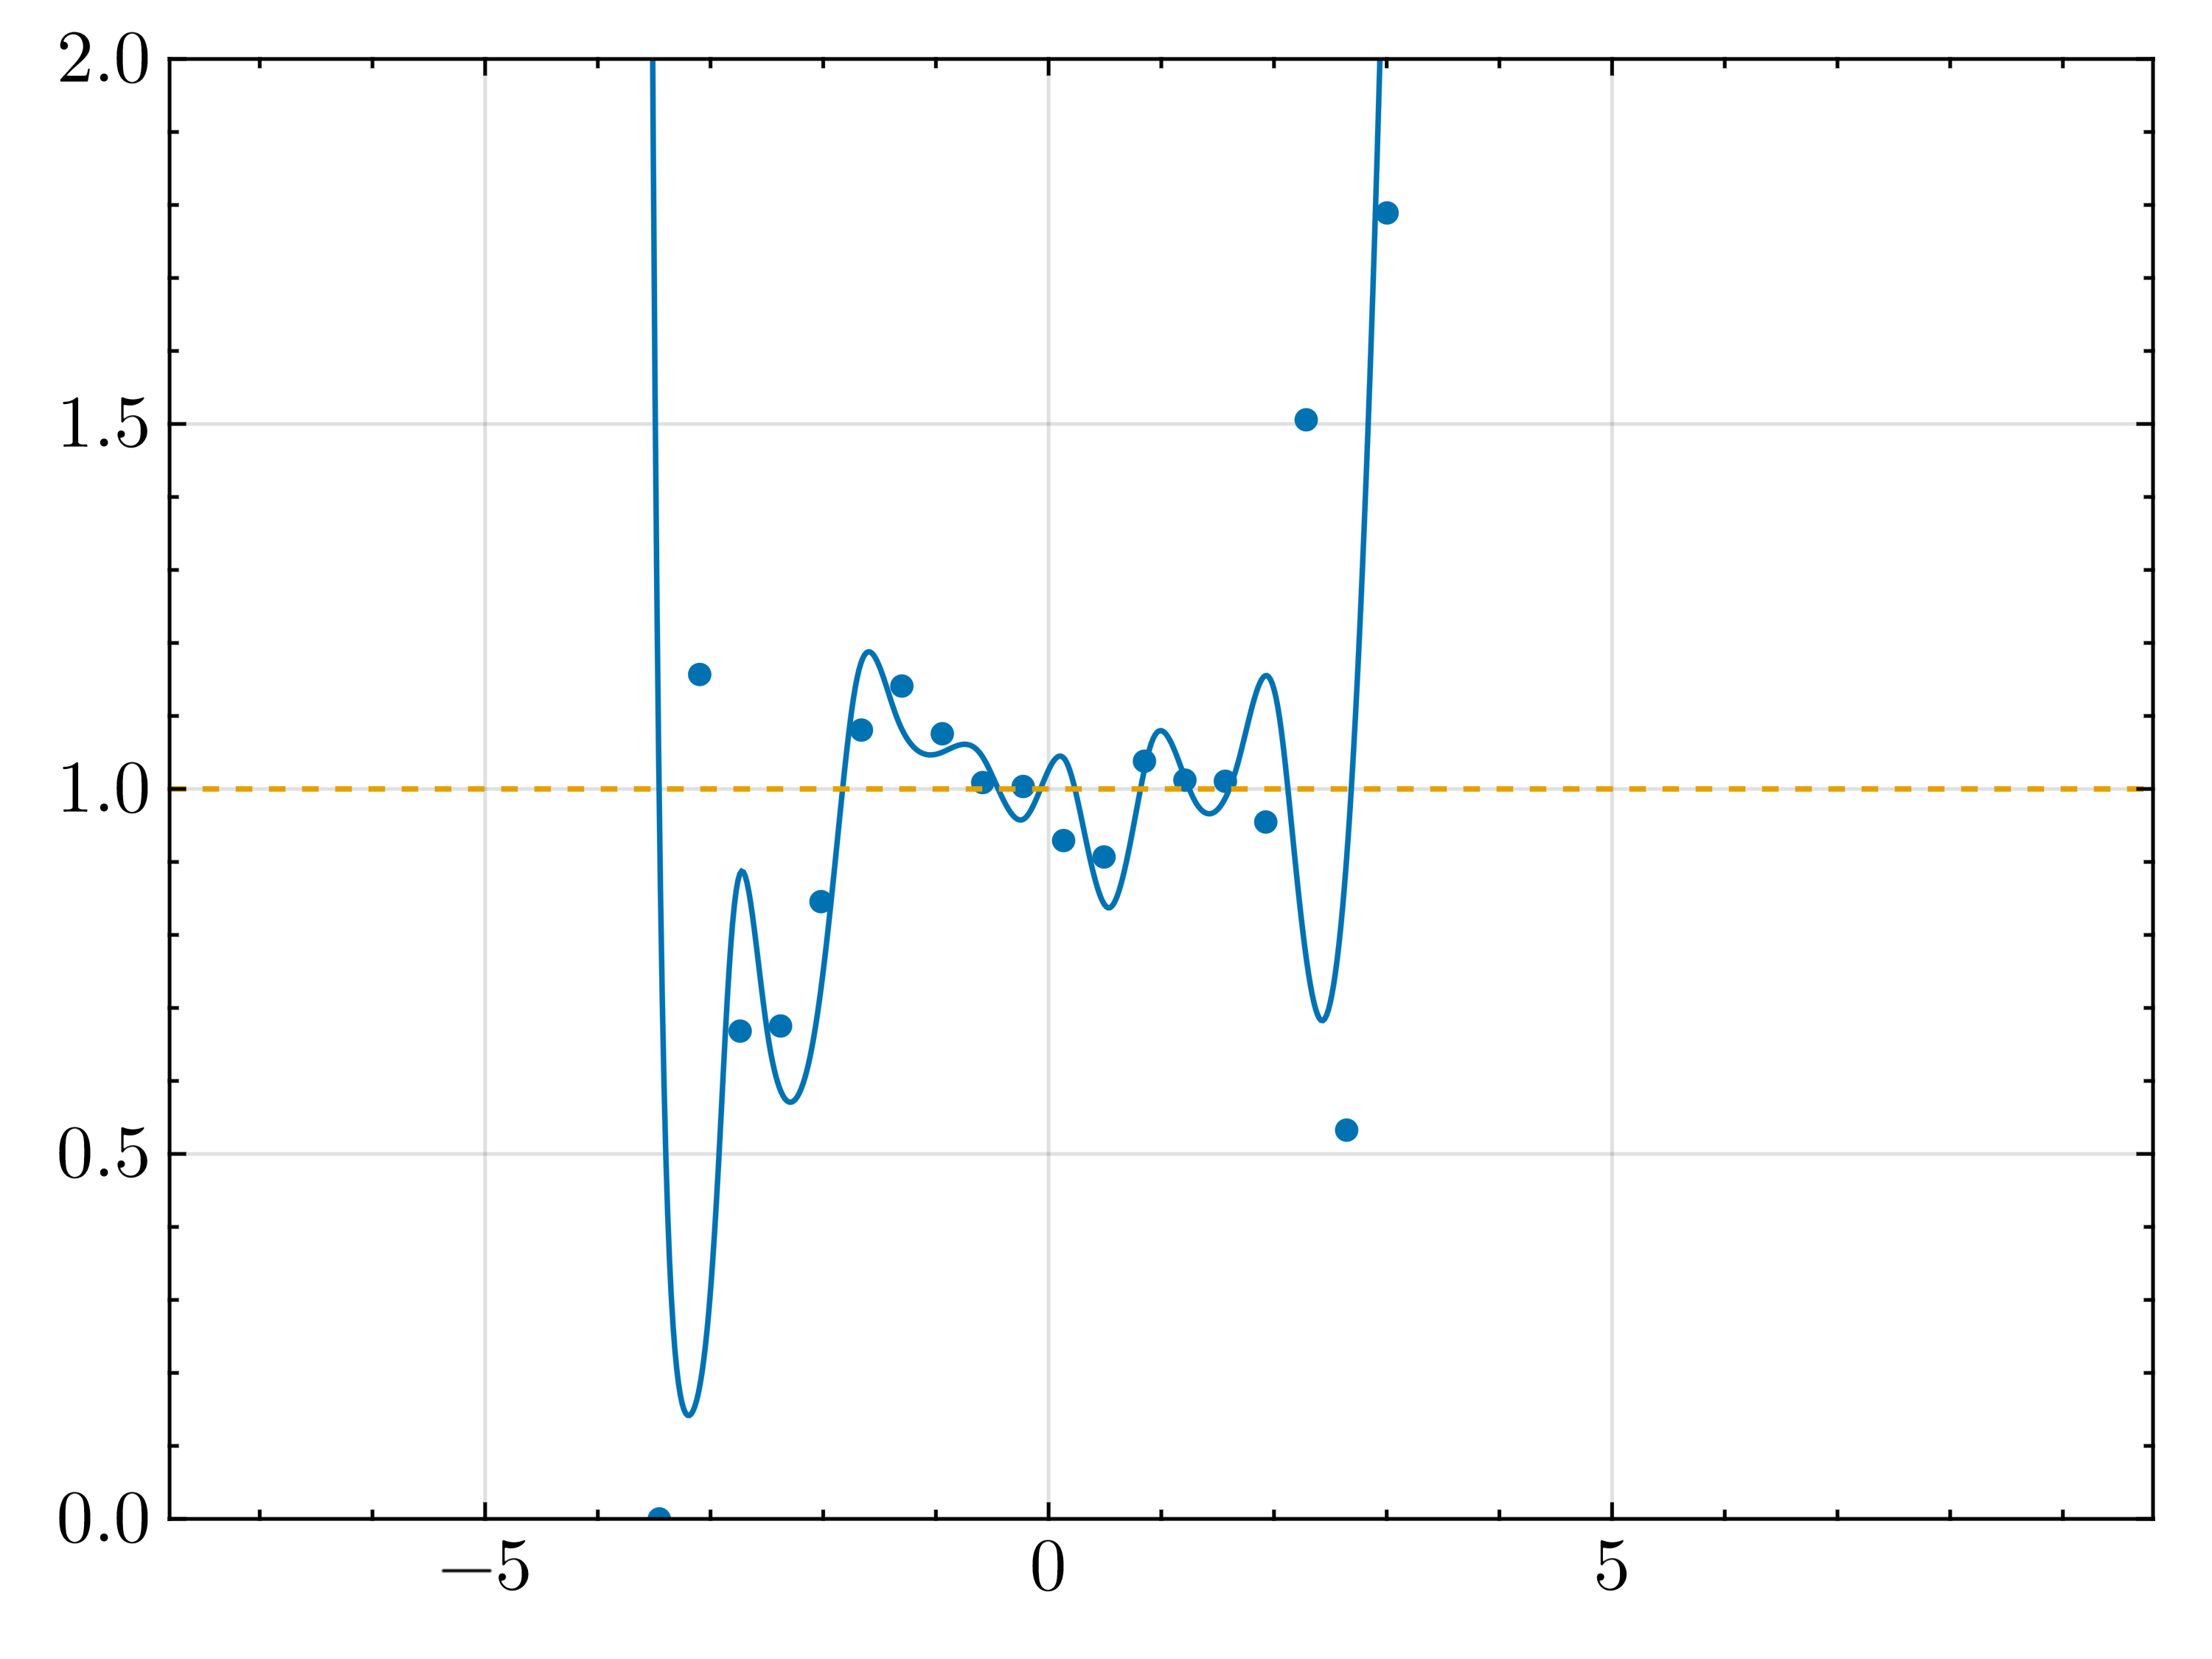

In [69]:
fig, ax = FigAxis(
limits=(nothing, (0, 2))
    )

h = DE.histogram(x, Nk, normalization=:pdf)
plot!(midpoints(h.bins), h.values ./ pdf.(dist_normal, midpoints(h.bins)))

x_m = LinRange(-7, 9, 1000)
y_m = s_best.(x_m) ./ pdf.(dist_normal, x_m)
lines!(x_m, y_m)
hlines!(1, color=COLORS[2], linestyle=:dash)

fig